In [7]:
import pandas as pd
import scipy as sc
import numpy as np
from numpy import mean

 <b>Import Data </b>

In [471]:
df = pd.read_csv('Train.txt',header=None)
Labels_Train=df[0]
df=df.drop(0, axis=1)
Labels_Train

0       5
1       3
2       3
3       3
4       3
       ..
1209    3
1210    3
1211    3
1212    3
1213    3
Name: 0, Length: 1214, dtype: int64

<b>Replace 3 to 1 and 5 to -1.</b>

In [472]:
Labels_Train=Labels_Train.replace(3,1)
Labels_Train=Labels_Train.replace(5,-1)
count = (Labels_Train == 1).value_counts()
Labels_Train

0      -1
1       1
2       1
3       1
4       1
       ..
1209    1
1210    1
1211    1
1212    1
1213    1
Name: 0, Length: 1214, dtype: int64

 <b>Plot Data distribution </b>

<BarContainer object of 2 artists>

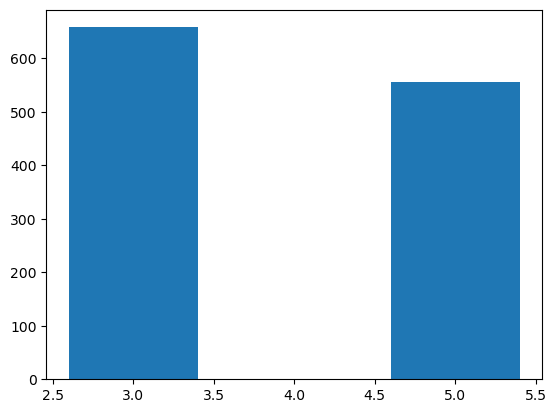

In [473]:
import matplotlib.pyplot as plt
p=(Labels_Train == 1).value_counts()[True]
q=(Labels_Train == 1).value_counts()[False]
y= np.array([p,q])
x= np.array([3,5])
plt.bar(x,y)

<b>Converting values to List from Series Dataframe</b>

In [474]:
Labels_Train=Labels_Train.to_numpy()
df=df.to_numpy()

 <b>Implementation of Decision Stump </b>

In [476]:
import numpy as np

class DecisionStump:
    def __init__(self):
        self.split_feature = None
        self.split_threshold = None
        self.split_direction = None

    def fit(self, X, y, sample_weight=None):
        # calculate Gini index for each feature and threshold
        n_samples, n_features = X.shape
        if sample_weight is None or len(sample_weight)==0:
            sample_weight = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
        best_gini = 1
        for feature in range(n_features):
            values = np.unique(X[:, feature])
            #print(feature)
            for threshold in values:
                left_mask = X[:, feature] <= threshold
                right_mask = X[:, feature] > threshold
                left_labels = y[left_mask]
                right_labels = y[right_mask]
                left_weight = sample_weight[left_mask].sum()
                right_weight = sample_weight[right_mask].sum()
                if left_labels.size > 0 and right_labels.size > 0:
                    gini = (left_weight * (1 - np.sum((left_labels == 1) * sample_weight[left_mask] / left_weight) ** 2 
                                          - np.sum((left_labels == -1) * sample_weight[left_mask] / left_weight) ** 2)
                            + right_weight * (1 - np.sum((right_labels == 1) * sample_weight[right_mask] / right_weight) ** 2 
                                              - np.sum((right_labels == -1) * sample_weight[right_mask] / right_weight) ** 2))
                    if gini < best_gini:
                        best_gini = gini
                        self.split_feature = feature
                        self.split_threshold = threshold
                        self.split_direction = 1
                        # Flip direction if Gini index is lower
                        # when right direction is negative
                        if np.sum((left_labels == -1) * sample_weight[left_mask] / left_weight) ** 2 < \
                           np.sum((right_labels == -1) * sample_weight[right_mask] / right_weight) ** 2:
                            self.split_direction = -1


    def predict(self, X):
        # make predictions based on the optimal split
        n_samples = X.shape[0]
        y_pred = np.zeros(n_samples)
        if self.split_feature is not None and self.split_threshold is not None:
            if self.split_direction == 1:
                y_pred[X[:, self.split_feature] <= self.split_threshold] = -1
                y_pred[X[:, self.split_feature] > self.split_threshold] = 1
            else:
                y_pred[X[:, self.split_feature] <= self.split_threshold] = 1
                y_pred[X[:, self.split_feature] > self.split_threshold] = -1
        return y_pred

 <b>Helper Functions </b>

In [492]:
def compute_error(y, y_pred, w_i):
    #Calculate the error rate of a weak classifier m. Arguments:
   
    return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)

def compute_alpha(error):  
    #Calculate the weight of a weak classifier m in the majority vote of the final classifier. 
    
    return (0.5/np.log(2))*np.log((1 - error) / error)

def update_weights(w_i, alpha, y, y_pred):
   #Update individual weights w_i after a boosting iteration. Arguments:
    #print("np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))=",np.exp(alpha * (np.not_equal(y, y_pred)).astype(int)))
    return w_i * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))



def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [493]:
class AdaBoost:
    def __init__(self):
        self.alphas = []
        self.ensambles = []
        self.M = None
        self.training_errors = []
        self.prediction_errors = []
        self.rounds=[]

    def fit(self, X, y, M):
       
        equal_probablity=[]
        # Clear before calling
        self.alphas = []   
        self.training_errors = []  
        self.M = M  
        prob=np.ones(len(X)) * 1 / len(y)
        # Iterate over M weak classifiers
        
        for m in range(0, M):
            n_samples=len(X)
            
            # Set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
                equal_probablity =w_i
            else:
                # (d) Update w_i
                w_i = update_weights(w_i, alpha_m, y, y_pred)
                w_i /=np.sum(w_i)
            
           
            sample_indices = np.random.choice(np.arange(n_samples), size=n_samples, p=w_i)
            X1, y1 = X[sample_indices], y[sample_indices]
        
            current_ensambles = DecisionStump()
            current_ensambles.fit(X1, y1, w_i)
            y_pred = current_ensambles.predict(X) 
          

            
            
            # (b) Compute error
            error_m = compute_error(y, y_pred, w_i)
            if error_m > 0.5:
                print(f"Error rate ({error_m}) is greater than 0.5. Repeating loop...")
                m -= 1  # decrease m by 1 to repeat the current iteration
                w_i = np.ones(len(y)) * 1 / len(y) 
                continue
                
                
            self.training_errors.append(error_m)
            self.rounds.append(m)
            self.ensambles.append(current_ensambles) # Save to list of weak classifiers
            
            
            
            # (c) Compute alpha
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)
            #print('m=',m,'  M=',self.M)
            #print('Round:',m,'   , Training Rate:_errors: ',error_m,'  , Alpha: ',alpha_m)
        assert len(self.ensambles) == len(self.alphas)
        
        
    def predict(self, X):
    
        # Initialise dataframe with weak predictions for each observation
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 

        # Predict class label for each weak classifier, weighted by alpha_m
        len(self.alphas)
        for m in range(len(self.ensambles)):
            y_pred_m = self.ensambles[m].predict(X) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m

        # Estimate final predictions
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return y_pred

In [486]:
#Helper Function for calculating accuracy

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

Iterations:  10 ,   Accuracy: 0.9299835255354201


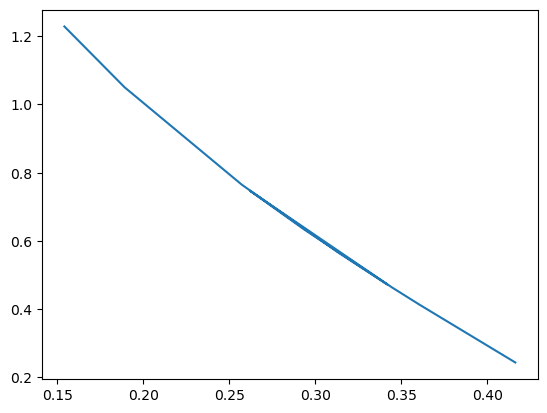

Iterations:  20 ,   Accuracy: 0.9596375617792422


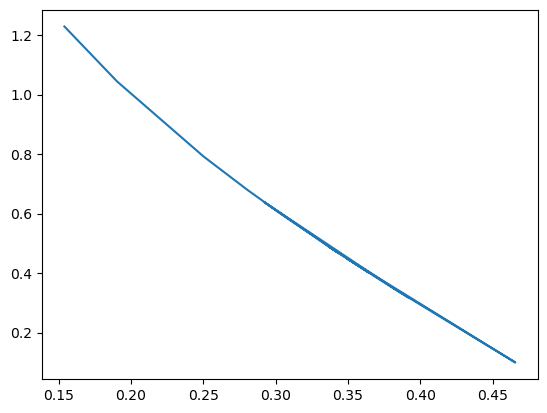

Iterations:  30 ,   Accuracy: 0.9728171334431631


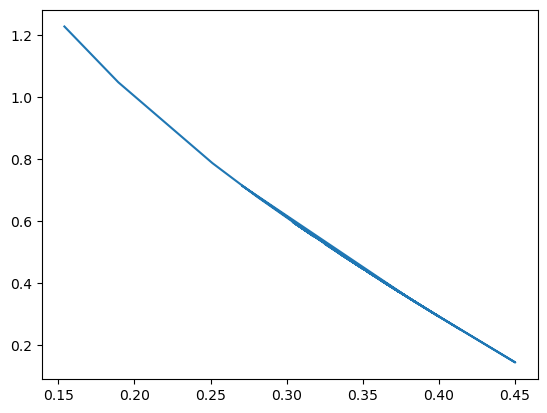

Iterations:  40 ,   Accuracy: 0.9703459637561779


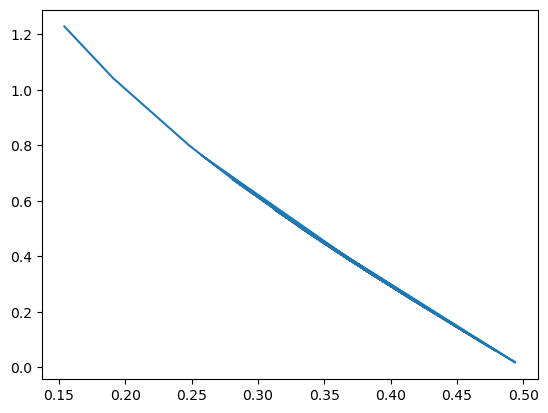

Iterations:  50 ,   Accuracy: 0.9818780889621087


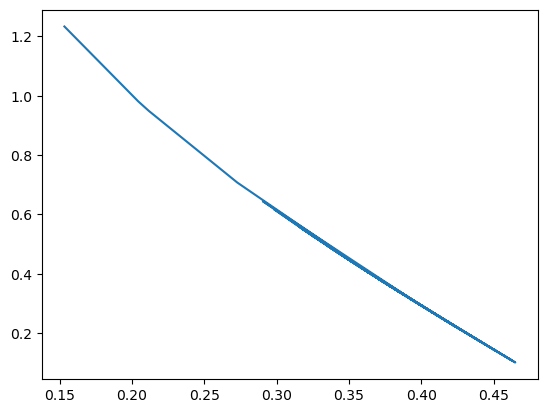

Error rate (0.507185053767023) is greater than 0.5. Repeating loop...
Iterations:  60 ,   Accuracy: 0.9728171334431631


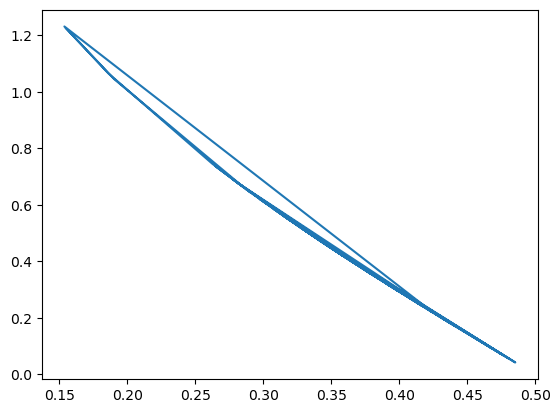

Error rate (0.5160931765252601) is greater than 0.5. Repeating loop...
Iterations:  70 ,   Accuracy: 0.9686985172981878


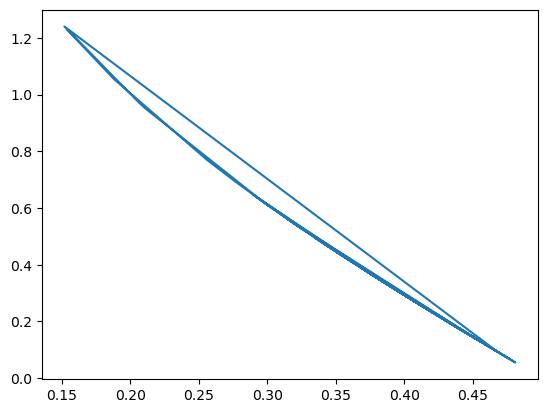

Iterations:  80 ,   Accuracy: 0.9901153212520593


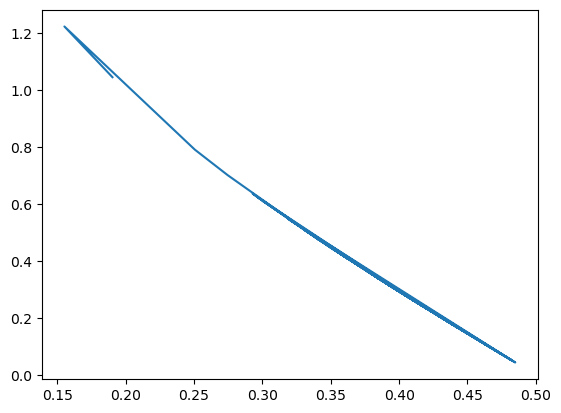

Error rate (0.5109485852688501) is greater than 0.5. Repeating loop...
Iterations:  90 ,   Accuracy: 0.9827018121911038


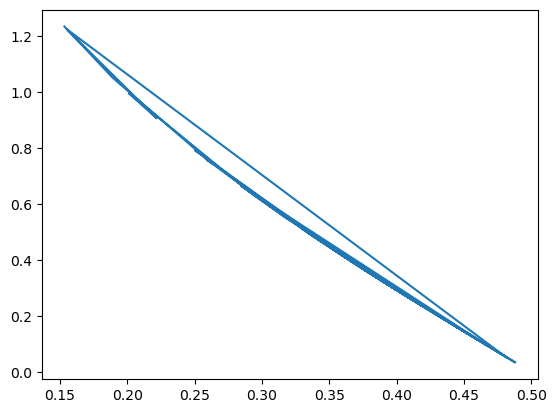

Error rate (0.5164604900539136) is greater than 0.5. Repeating loop...
Iterations:  100 ,   Accuracy: 0.9818780889621087


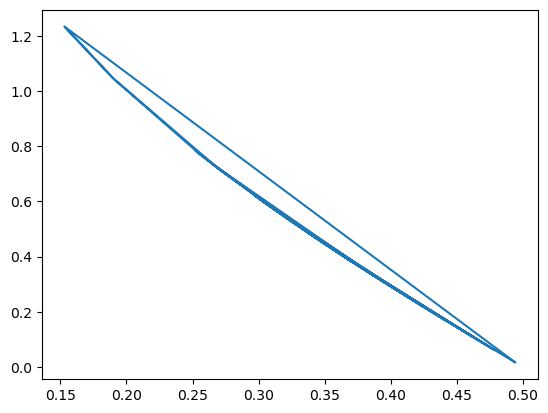

Error rate (0.5037735258192203) is greater than 0.5. Repeating loop...
Iterations:  110 ,   Accuracy: 0.985996705107084


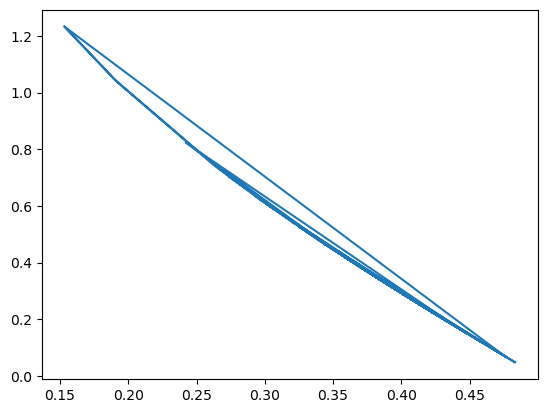

Iterations:  120 ,   Accuracy: 0.9950576606260296


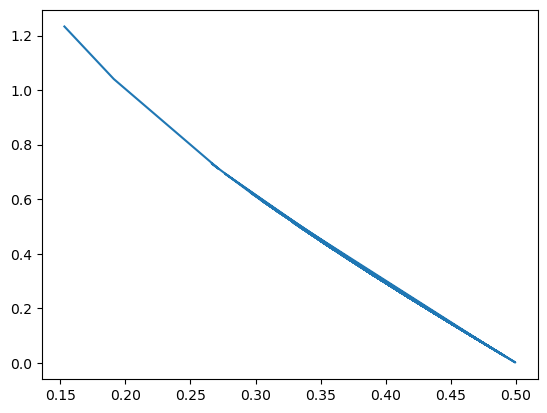

Error rate (0.5102427697695544) is greater than 0.5. Repeating loop...
Iterations:  130 ,   Accuracy: 0.9876441515650741


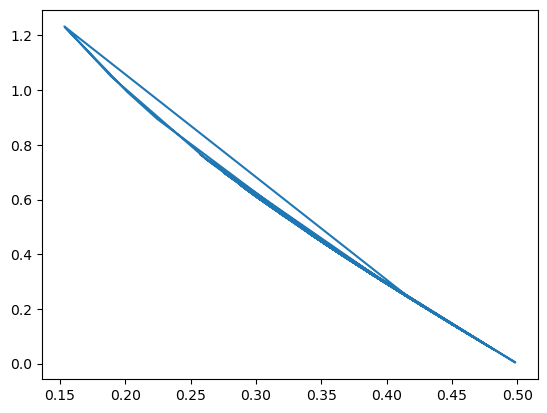

Error rate (0.5008266183578906) is greater than 0.5. Repeating loop...
Error rate (0.5024254515149991) is greater than 0.5. Repeating loop...
Error rate (0.5165261397051317) is greater than 0.5. Repeating loop...
Iterations:  140 ,   Accuracy: 0.9761120263591433


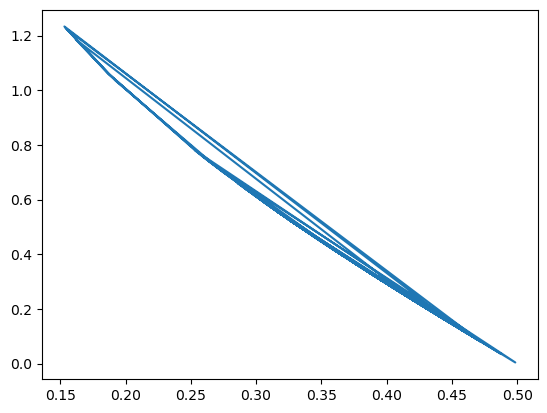

Error rate (0.5161410544742469) is greater than 0.5. Repeating loop...
Error rate (0.5084425317108379) is greater than 0.5. Repeating loop...
Error rate (0.5024951137487899) is greater than 0.5. Repeating loop...
Iterations:  150 ,   Accuracy: 0.9785831960461285


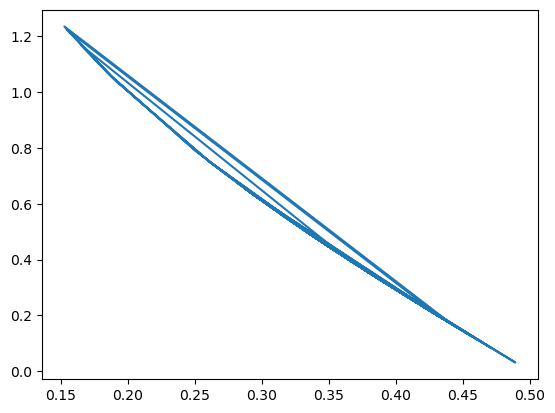

Error rate (0.5008908313370798) is greater than 0.5. Repeating loop...
Error rate (0.5101529544571948) is greater than 0.5. Repeating loop...
Iterations:  160 ,   Accuracy: 0.9810543657331137


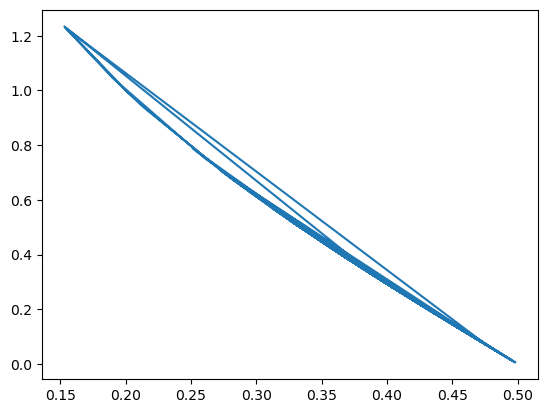

Error rate (0.5135508994300082) is greater than 0.5. Repeating loop...
Error rate (0.502614004453106) is greater than 0.5. Repeating loop...
Error rate (0.5047700312969571) is greater than 0.5. Repeating loop...
Iterations:  170 ,   Accuracy: 0.9802306425041186


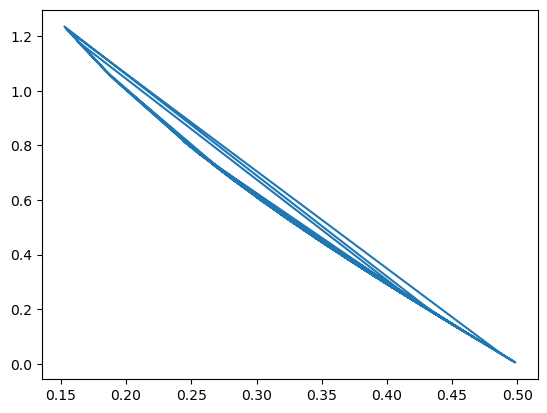

Error rate (0.515955199258022) is greater than 0.5. Repeating loop...
Error rate (0.5236431388681363) is greater than 0.5. Repeating loop...
Iterations:  180 ,   Accuracy: 0.9827018121911038


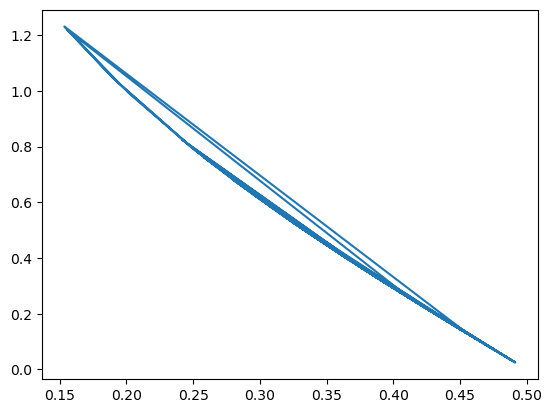

Error rate (0.5163653377683106) is greater than 0.5. Repeating loop...
Error rate (0.5074797519917418) is greater than 0.5. Repeating loop...
Error rate (0.5207489370446606) is greater than 0.5. Repeating loop...
Iterations:  190 ,   Accuracy: 0.9777594728171335


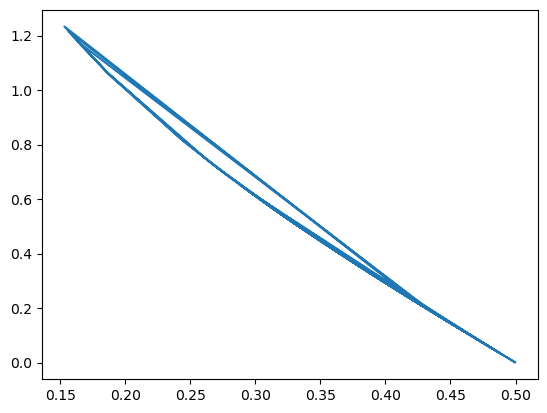

Error rate (0.5150328291322708) is greater than 0.5. Repeating loop...
Error rate (0.5103677156456772) is greater than 0.5. Repeating loop...
Error rate (0.5006298432428367) is greater than 0.5. Repeating loop...
Iterations:  200 ,   Accuracy: 0.9827018121911038


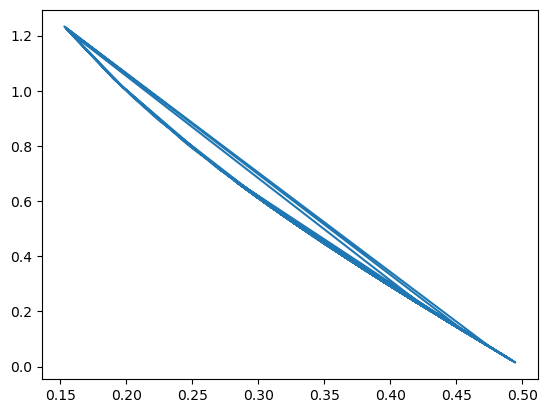

In [495]:
import matplotlib.pyplot as plt

ensamble_accuracy=[]
myAdadBoostObjects=[]
for i in range (10,201,10):  
    ab = AdaBoost()
    ab.fit(df, Labels_Train,i) 
    myAdadBoostObjects.append(ab)
    # Predict on test set
    y_pred = ab.predict(df)
    acc = accuracy(Labels_Train, y_pred)
    print('Iterations: ',i,",   Accuracy:", acc)
    
    df_Test = pd.read_csv('Test.txt',header=None)
    df_Test=df_Test.to_numpy()
    y_Test_pred = ab.predict(df_Test)
   
    y_Test_pred=y_Test_pred.replace(1,3)
    y_Test_pred=y_Test_pred.replace(-1,5)
    
    writeToFile(i,y_Test_pred)
    plt.plot((ab.training_errors),ab.alphas)
    
    plt.show()
    ensamble_accuracy.append(acc)


Iterations:  10 ,   Accuracy: 0.942339373970346


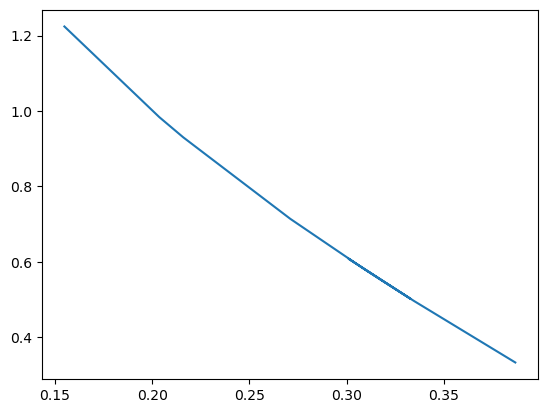

Iterations:  20 ,   Accuracy: 0.9629324546952224


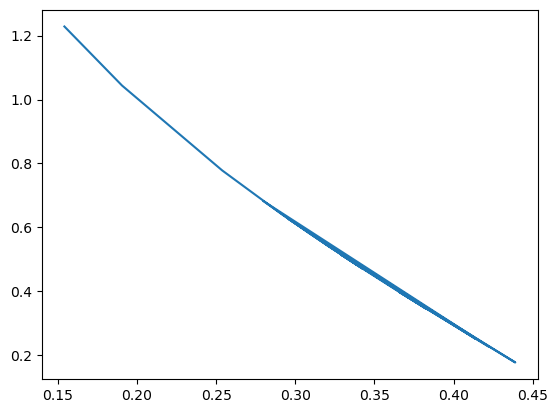

Iterations:  30 ,   Accuracy: 0.9686985172981878


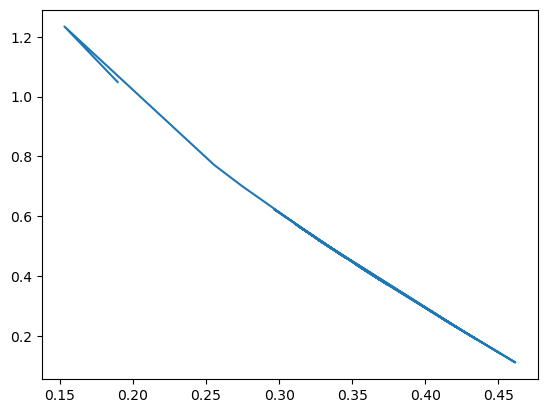

Error rate (0.5129547668823483) is greater than 0.5. Repeating loop...
Iterations:  40 ,   Accuracy: 0.9621087314662273


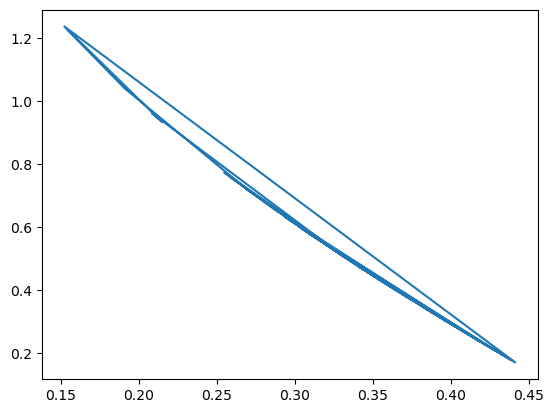

Iterations:  50 ,   Accuracy: 0.9769357495881383


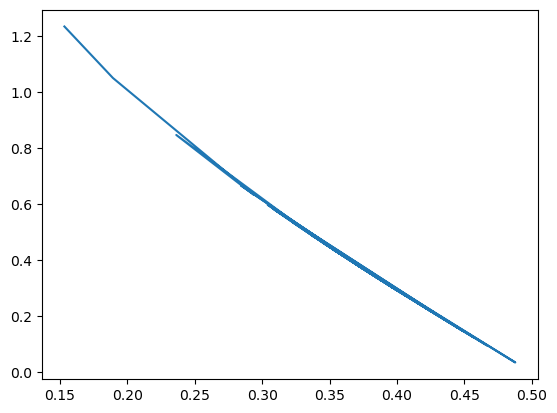

Iterations:  60 ,   Accuracy: 0.9835255354200988


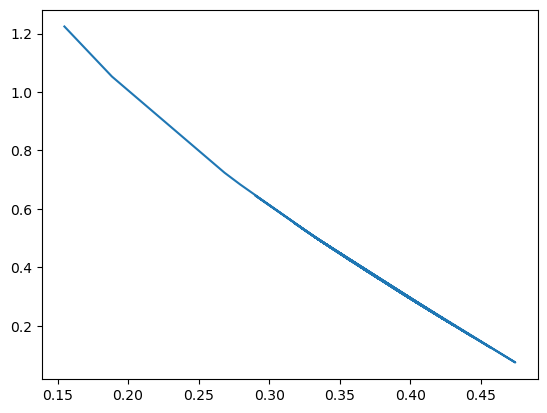

Error rate (0.5047827505503415) is greater than 0.5. Repeating loop...
Iterations:  70 ,   Accuracy: 0.9769357495881383


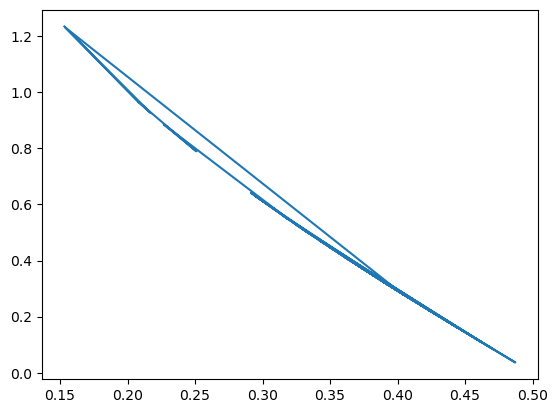

Error rate (0.510951383273481) is greater than 0.5. Repeating loop...
Iterations:  80 ,   Accuracy: 0.9703459637561779


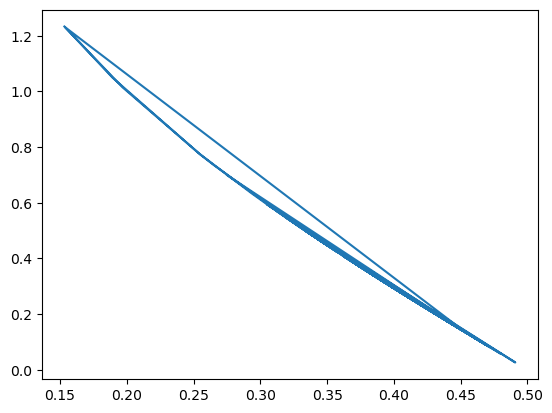

Error rate (0.5110386662650885) is greater than 0.5. Repeating loop...
Iterations:  90 ,   Accuracy: 0.9794069192751236


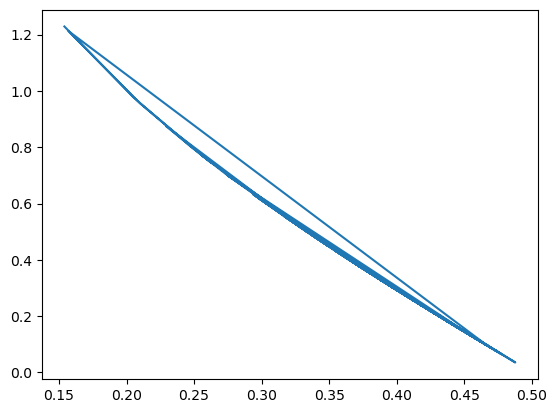

Error rate (0.5061646598049849) is greater than 0.5. Repeating loop...
Iterations:  100 ,   Accuracy: 0.984349258649094


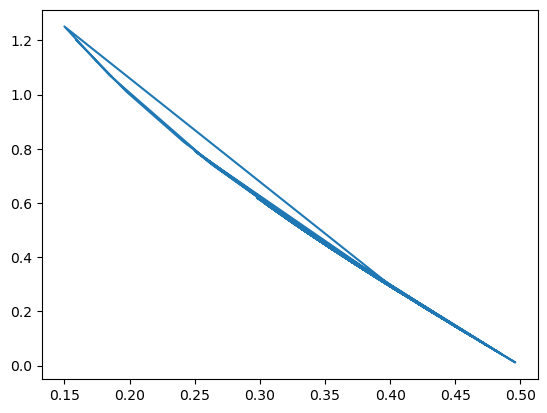

Error rate (0.5115359339855176) is greater than 0.5. Repeating loop...
Iterations:  110 ,   Accuracy: 0.9934102141680395


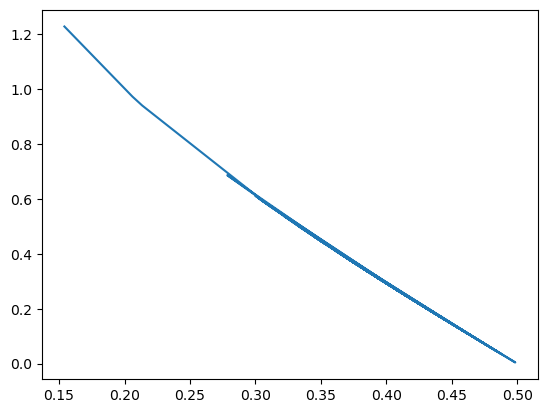

Error rate (0.508923352431507) is greater than 0.5. Repeating loop...
Iterations:  120 ,   Accuracy: 0.9810543657331137


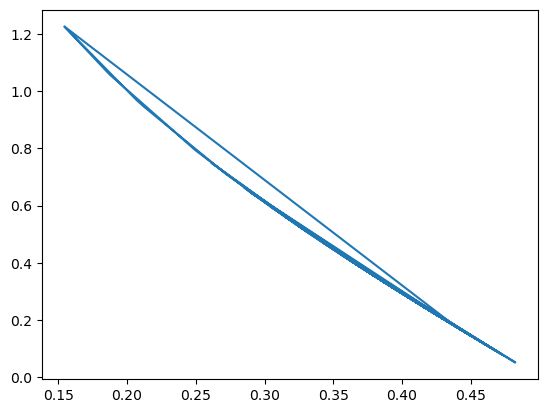

Error rate (0.5042867227695186) is greater than 0.5. Repeating loop...
Iterations:  130 ,   Accuracy: 0.9868204283360791


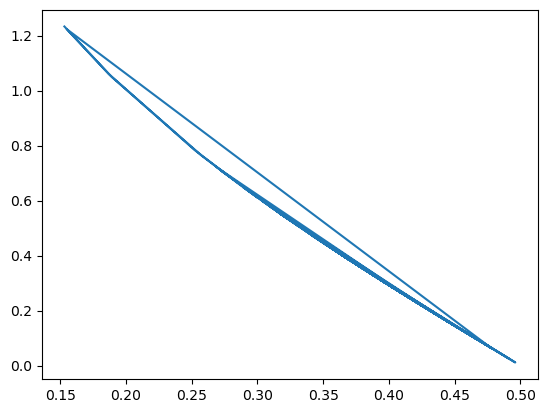

Error rate (0.5277756462023446) is greater than 0.5. Repeating loop...
Error rate (0.5036969117289645) is greater than 0.5. Repeating loop...
Iterations:  140 ,   Accuracy: 0.9810543657331137


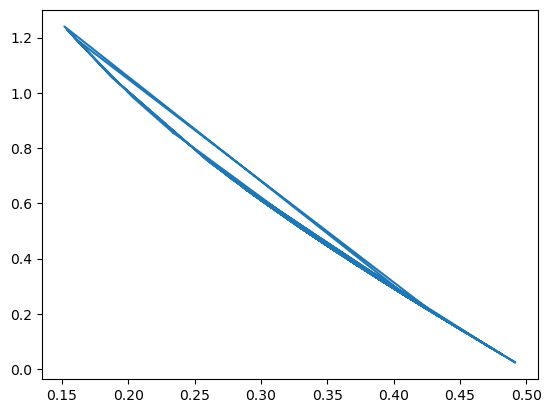

Error rate (0.5053670682921132) is greater than 0.5. Repeating loop...
Error rate (0.5069568219278778) is greater than 0.5. Repeating loop...
Error rate (0.5088485775302461) is greater than 0.5. Repeating loop...
Iterations:  150 ,   Accuracy: 0.9752883031301482


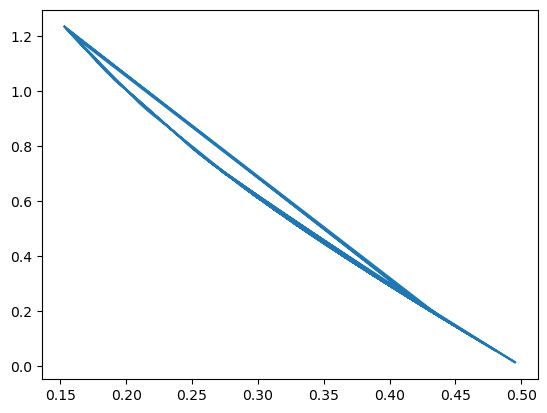

Error rate (0.5091791177937973) is greater than 0.5. Repeating loop...
Iterations:  160 ,   Accuracy: 0.9876441515650741


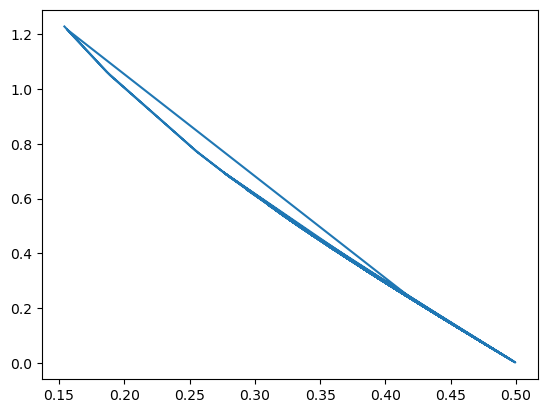

Error rate (0.50184761891811) is greater than 0.5. Repeating loop...
Error rate (0.5208015164392054) is greater than 0.5. Repeating loop...
Error rate (0.5033244582812463) is greater than 0.5. Repeating loop...
Iterations:  170 ,   Accuracy: 0.9777594728171335


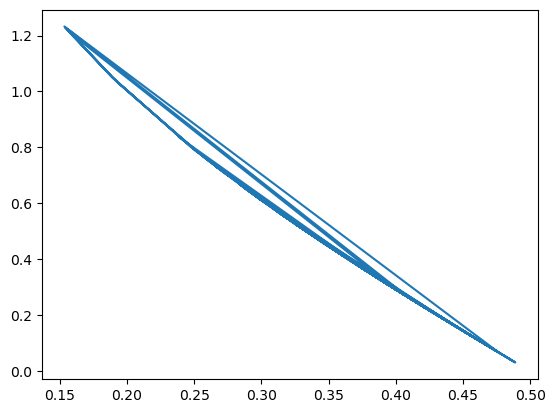

Error rate (0.5107527597667646) is greater than 0.5. Repeating loop...
Iterations:  180 ,   Accuracy: 0.9934102141680395


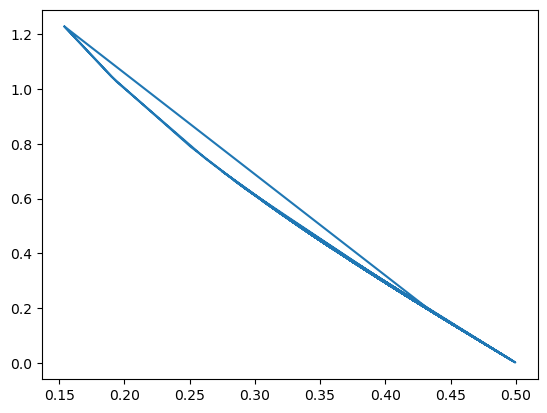

Error rate (0.5116221361423289) is greater than 0.5. Repeating loop...
Iterations:  190 ,   Accuracy: 0.9934102141680395


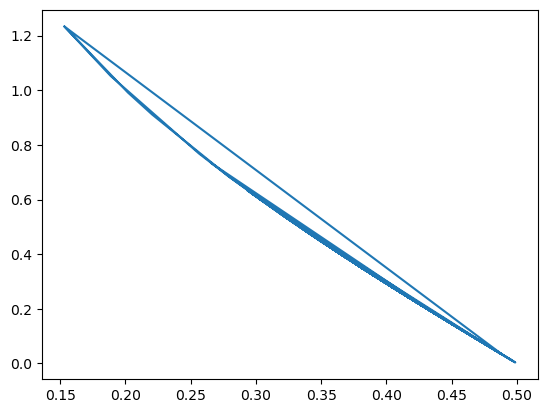

Error rate (0.5025132658688442) is greater than 0.5. Repeating loop...
Error rate (0.5041296011545267) is greater than 0.5. Repeating loop...
Iterations:  200 ,   Accuracy: 0.9901153212520593


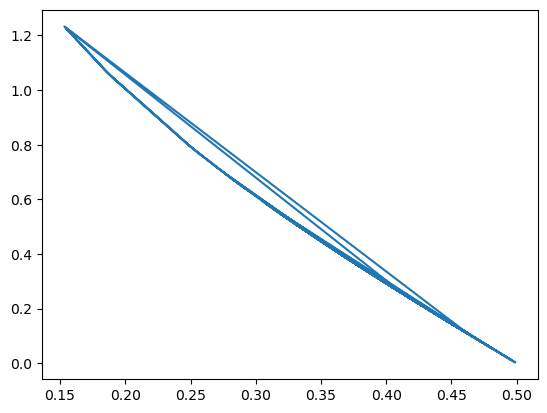

In [462]:
import matplotlib.pyplot as plt

#After DATA MINING LECTURE Experiment

accuracies=[]
for i in range (10,201,10):  
    ab = AdaBoost()
    ab.fit(df, Labels_Train,i) #50
    
    # Predict on test set
    y_pred = ab.predict(df)
    acc = accuracy(Labels_Train, y_pred)
    print('Iterations: ',i,",   Accuracy:", acc)
    
    df_Test = pd.read_csv('Test.txt',header=None)
    df_Test=df_Test.to_numpy()
    y_Test_pred = ab.predict(df_Test)
   
    y_Test_pred=y_Test_pred.replace(1,3)
    y_Test_pred=y_Test_pred.replace(-1,5)
    
    writeToFile(i,y_Test_pred)
    plt.plot((ab.training_errors),ab.alphas)
    
    plt.show()
    accuracies.append(acc)


Iterations:  10 ,   Accuracy: 0.9316309719934102


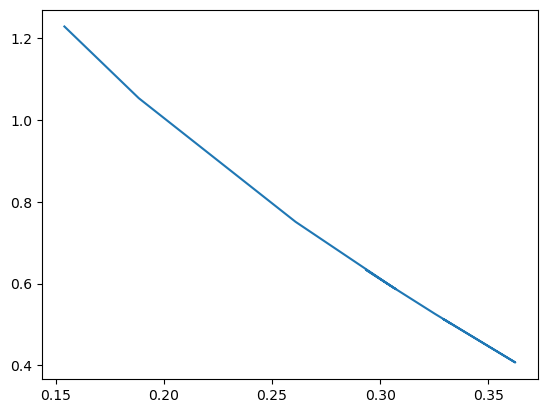

Iterations:  20 ,   Accuracy: 0.9588138385502472


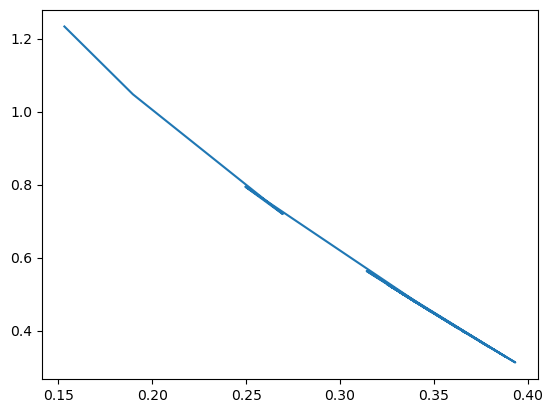

Iterations:  30 ,   Accuracy: 0.9695222405271828


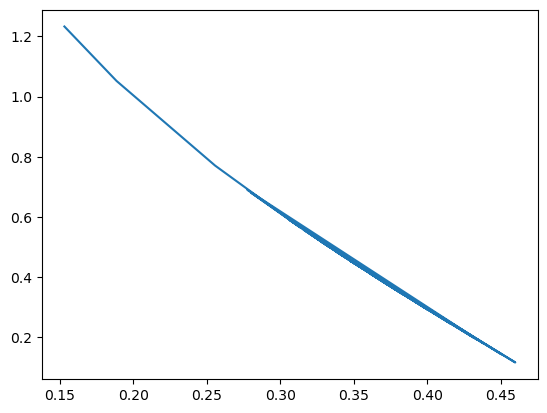

Iterations:  40 ,   Accuracy: 0.9802306425041186


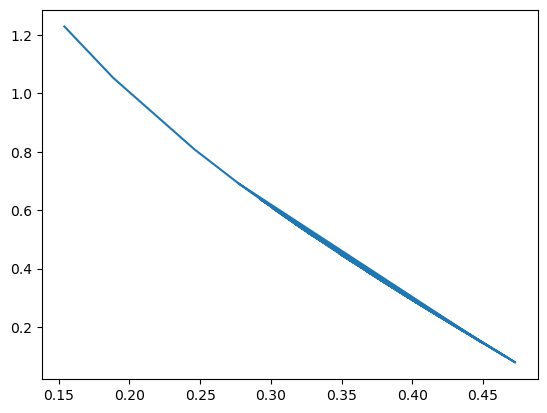

Error rate (0.5386203247607919) is greater than 0.5. Repeating loop...
Iterations:  50 ,   Accuracy: 0.9654036243822076


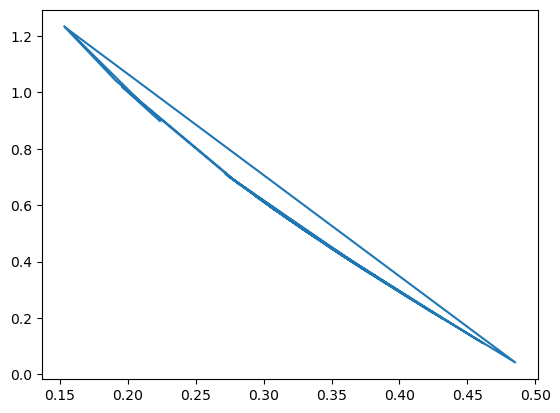

Error rate (0.5199241657549678) is greater than 0.5. Repeating loop...
Iterations:  60 ,   Accuracy: 0.9794069192751236


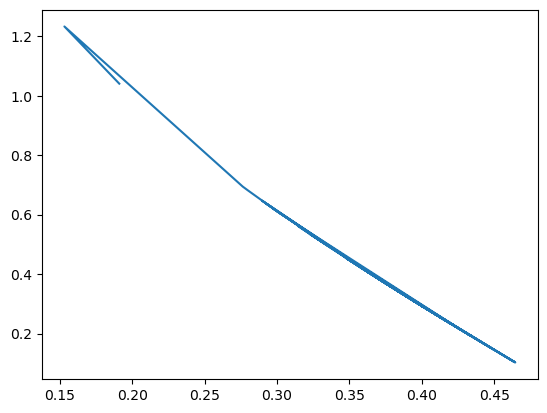

Iterations:  70 ,   Accuracy: 0.9876441515650741


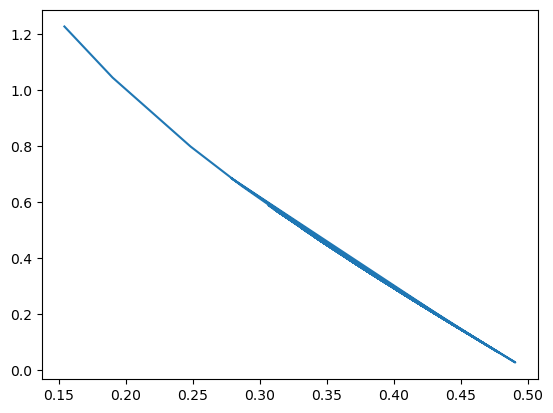

Iterations:  80 ,   Accuracy: 0.9901153212520593


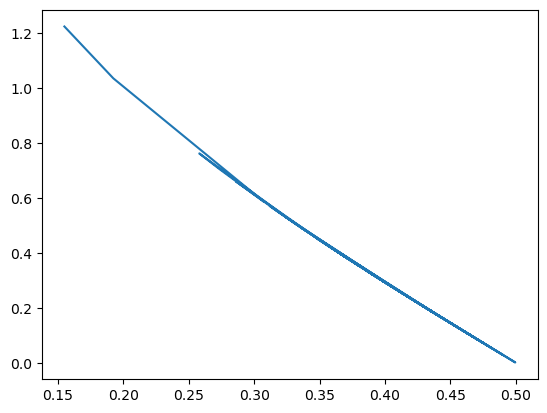

Error rate (0.5219755532069342) is greater than 0.5. Repeating loop...
Iterations:  90 ,   Accuracy: 0.9802306425041186


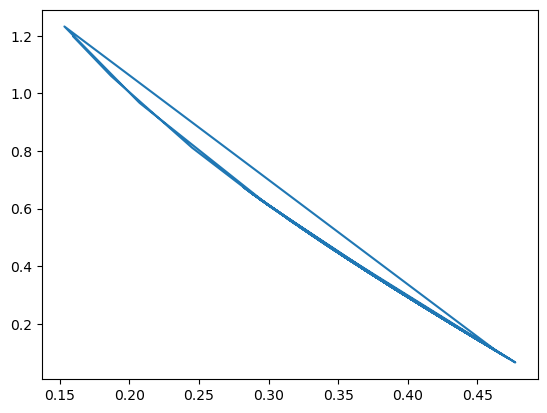

Error rate (0.5104846691670963) is greater than 0.5. Repeating loop...
Iterations:  100 ,   Accuracy: 0.9827018121911038


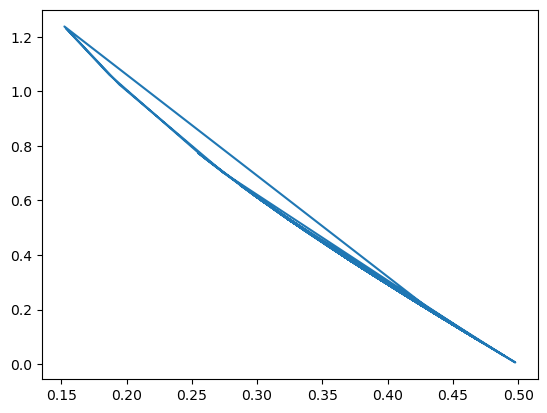

Error rate (0.5072584359601442) is greater than 0.5. Repeating loop...
Iterations:  110 ,   Accuracy: 0.985172981878089


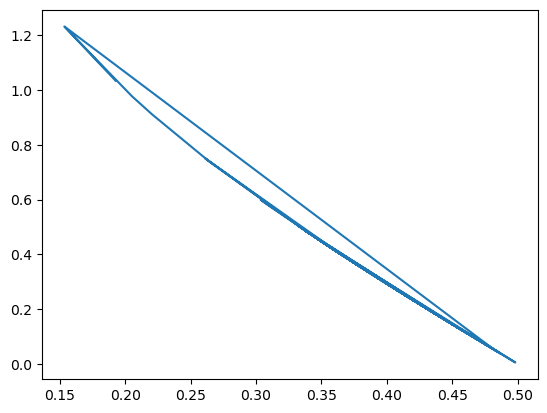

Error rate (0.5214342636929775) is greater than 0.5. Repeating loop...
Error rate (0.5138504855428422) is greater than 0.5. Repeating loop...
Iterations:  120 ,   Accuracy: 0.9777594728171335


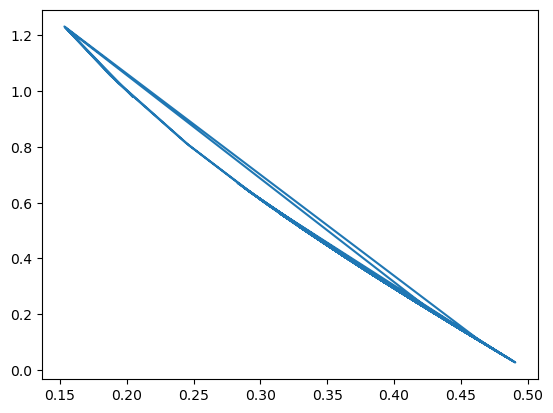

Error rate (0.5161082609932878) is greater than 0.5. Repeating loop...
Error rate (0.5016737482169754) is greater than 0.5. Repeating loop...
Iterations:  130 ,   Accuracy: 0.9818780889621087


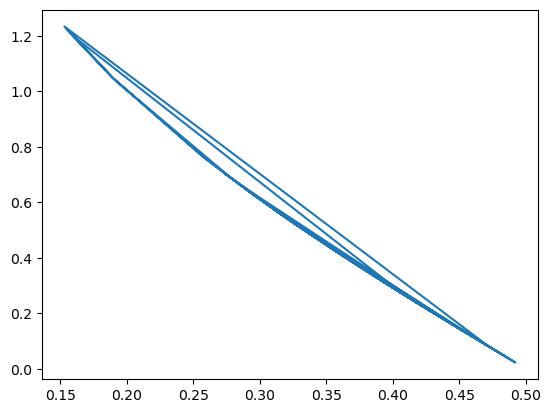

Error rate (0.5161835197885357) is greater than 0.5. Repeating loop...
Error rate (0.5124061582213344) is greater than 0.5. Repeating loop...
Error rate (0.5044509479097744) is greater than 0.5. Repeating loop...
Iterations:  140 ,   Accuracy: 0.9761120263591433


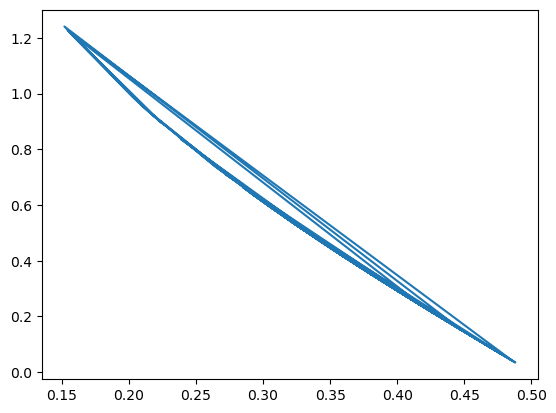

Error rate (0.5063007931367461) is greater than 0.5. Repeating loop...
Iterations:  150 ,   Accuracy: 0.9884678747940692


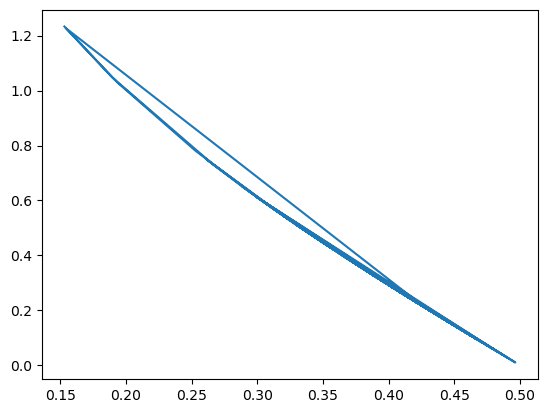

Error rate (0.532043358319369) is greater than 0.5. Repeating loop...
Error rate (0.511615959453844) is greater than 0.5. Repeating loop...
Iterations:  160 ,   Accuracy: 0.9827018121911038


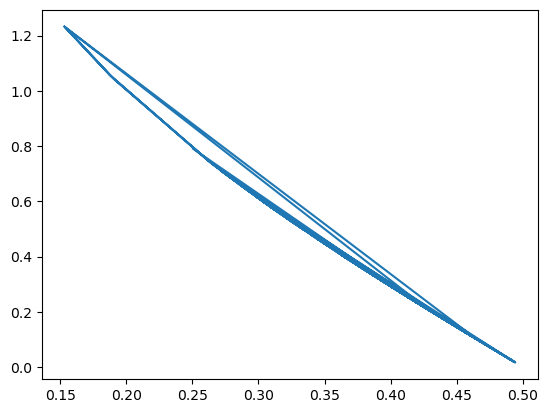

Error rate (0.5107769458920866) is greater than 0.5. Repeating loop...
Error rate (0.5024189661040851) is greater than 0.5. Repeating loop...
Iterations:  170 ,   Accuracy: 0.985996705107084


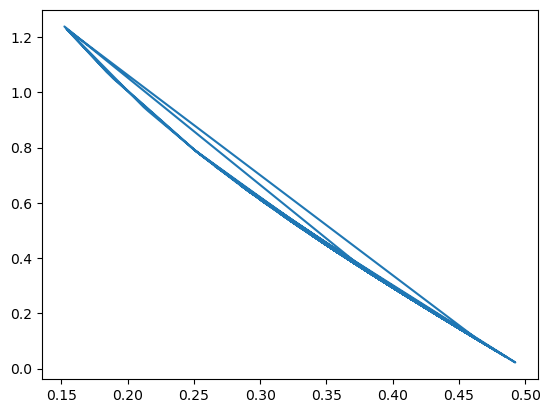

Error rate (0.5136756171589414) is greater than 0.5. Repeating loop...
Error rate (0.5136662726413523) is greater than 0.5. Repeating loop...
Error rate (0.5032483244769185) is greater than 0.5. Repeating loop...
Iterations:  180 ,   Accuracy: 0.9810543657331137


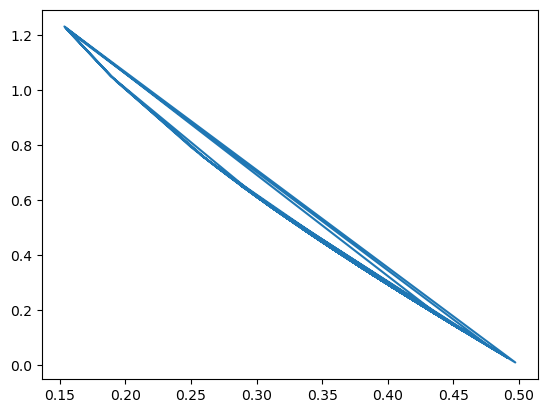

Error rate (0.511006461744307) is greater than 0.5. Repeating loop...
Error rate (0.5055076217297173) is greater than 0.5. Repeating loop...
Iterations:  190 ,   Accuracy: 0.9892915980230642


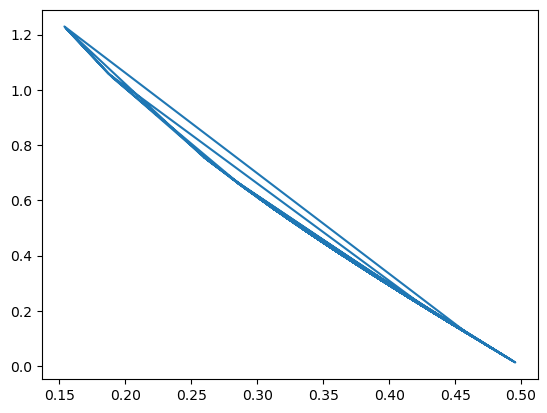

Error rate (0.50187141043098) is greater than 0.5. Repeating loop...
Error rate (0.5106243968685266) is greater than 0.5. Repeating loop...
Error rate (0.5216577816879818) is greater than 0.5. Repeating loop...
Iterations:  200 ,   Accuracy: 0.9810543657331137


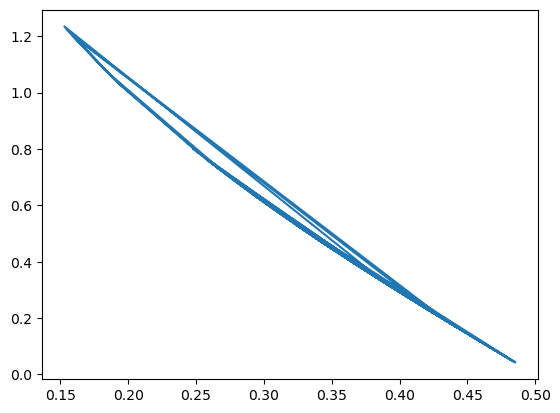

In [414]:
import matplotlib.pyplot as plt

accuracies=[]
for i in range (10,201,10):  
    ab = AdaBoost()
    ab.fit(df, Labels_Train,i) 
    
    y_pred = ab.predict(df)
    acc = accuracy(Labels_Train, y_pred)
    print('Iterations: ',i,",   Accuracy:", acc)
    
    df_Test = pd.read_csv('Test.txt',header=None)
    df_Test=df_Test.to_numpy()
    y_Test_pred = ab.predict(df_Test)
   
    y_Test_pred=y_Test_pred.replace(1,3)
    y_Test_pred=y_Test_pred.replace(-1,5)
    
    writeToFile(i,y_Test_pred)
    plt.plot((ab.training_errors),ab.alphas)
 
    plt.show()
    accuracies.append(acc)


Iterations:  10 ,   Accuracy: 0.9456342668863262


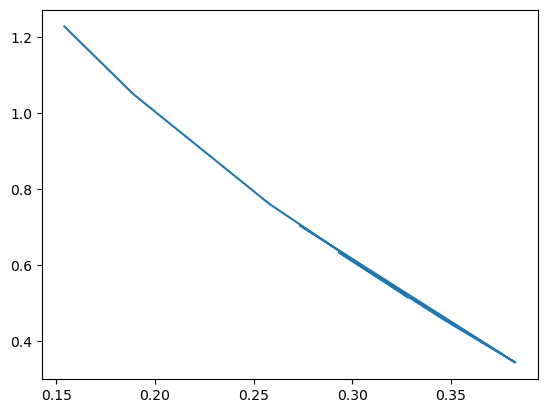

Iterations:  20 ,   Accuracy: 0.9596375617792422


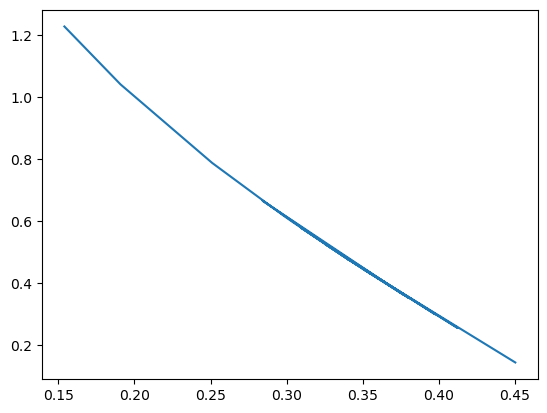

Iterations:  30 ,   Accuracy: 0.9769357495881383


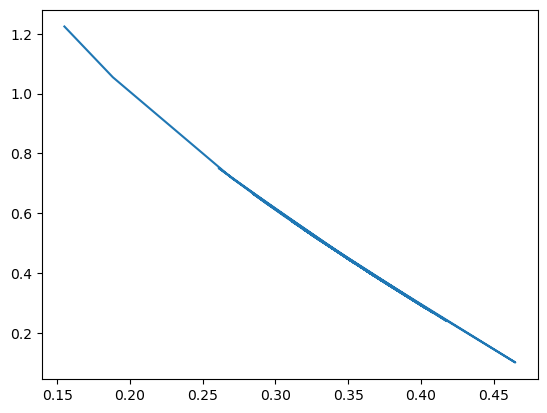

Iterations:  40 ,   Accuracy: 0.9785831960461285


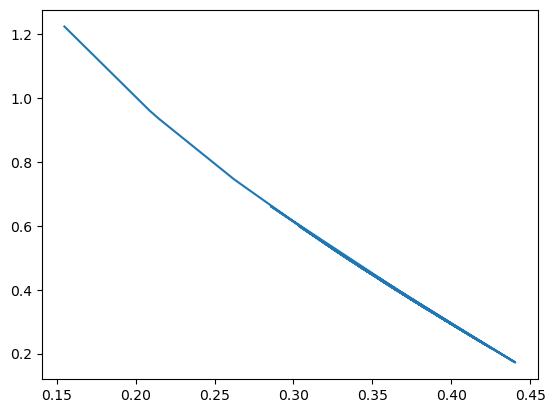

Iterations:  50 ,   Accuracy: 0.9777594728171335


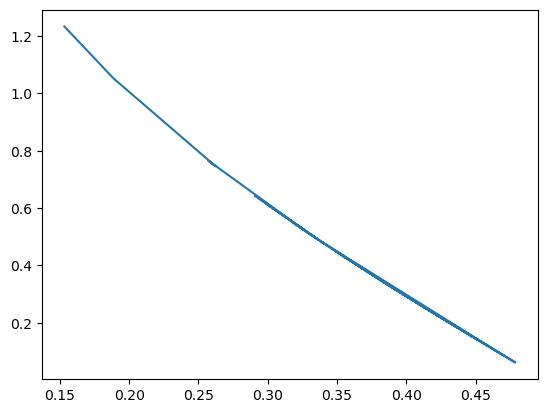

Iterations:  60 ,   Accuracy: 0.9876441515650741


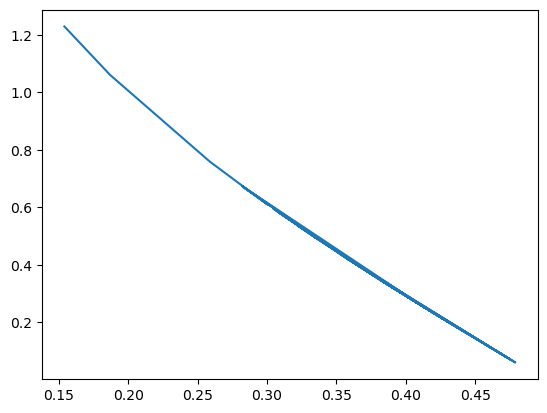

Iterations:  70 ,   Accuracy: 0.985996705107084


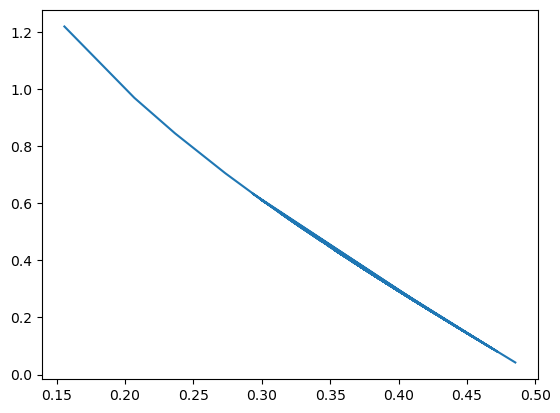

Error rate (0.500292631140564) is greater than 0.5. Repeating loop...
Iterations:  80 ,   Accuracy: 0.9810543657331137


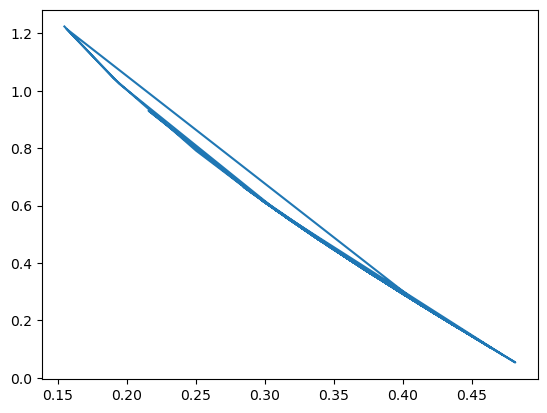

Iterations:  90 ,   Accuracy: 0.9917627677100495


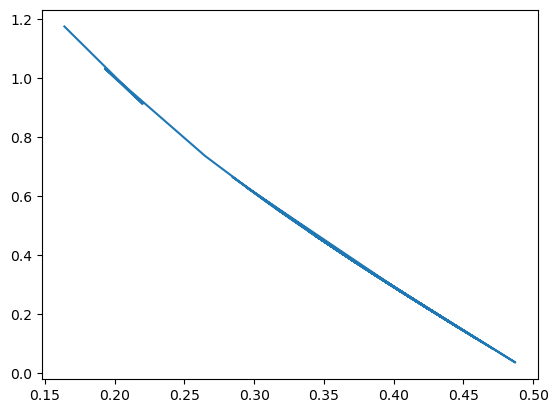

Iterations:  100 ,   Accuracy: 0.9909390444810544


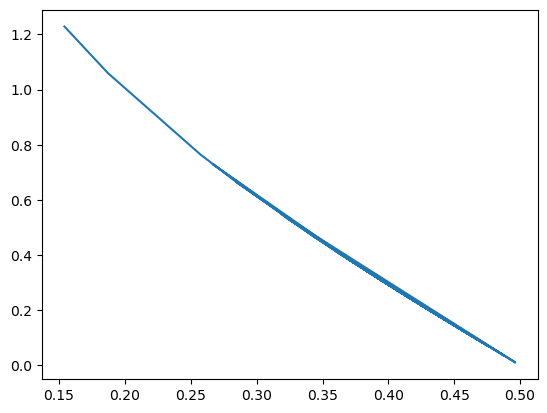

Iterations:  110 ,   Accuracy: 0.9942339373970346


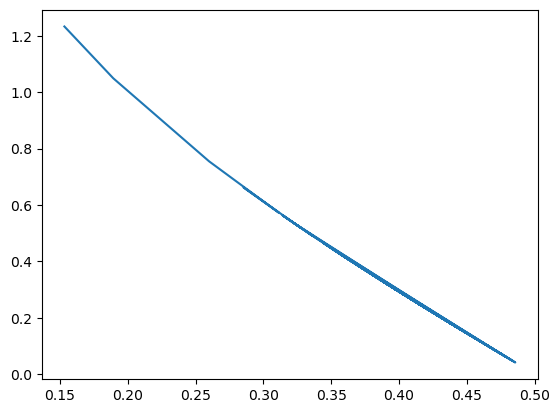

Error rate (0.5007806729493003) is greater than 0.5. Repeating loop...
Iterations:  120 ,   Accuracy: 0.9835255354200988


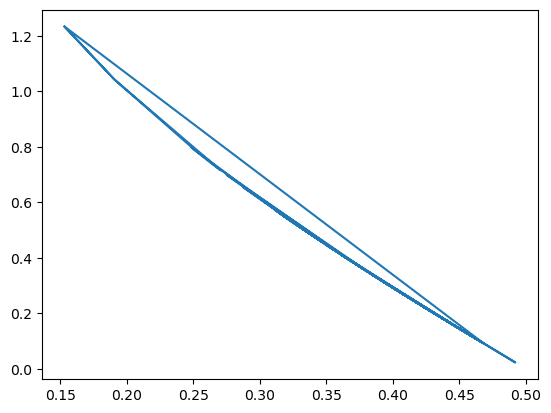

Error rate (0.5001528010077532) is greater than 0.5. Repeating loop...
Iterations:  130 ,   Accuracy: 0.985996705107084


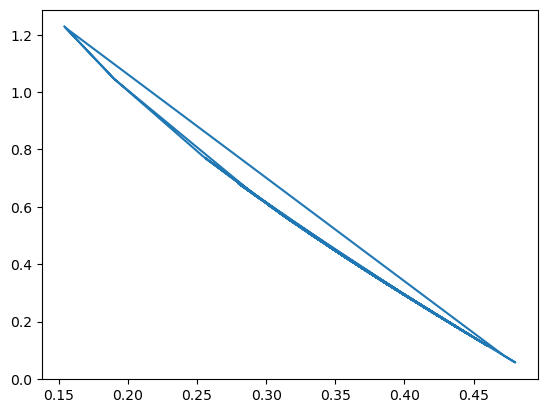

Iterations:  140 ,   Accuracy: 0.9983525535420099


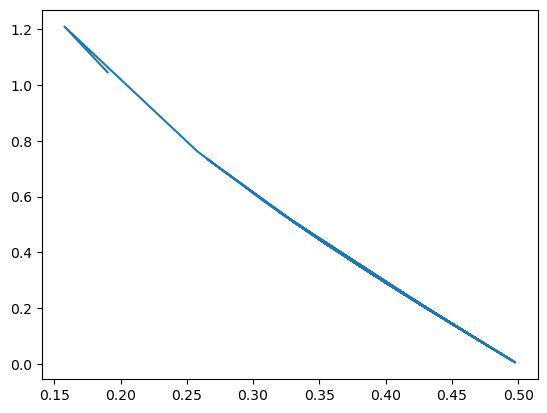

Iterations:  150 ,   Accuracy: 0.999176276771005


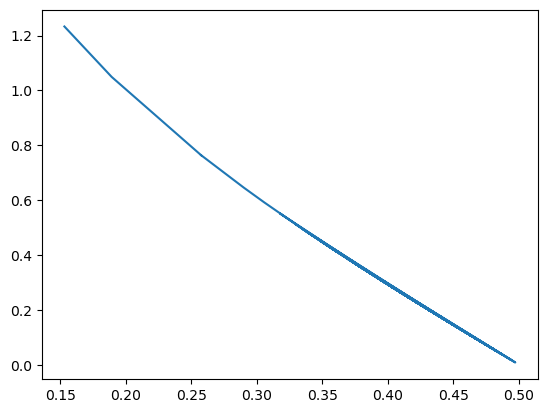

Error rate (0.5051309132912342) is greater than 0.5. Repeating loop...
Iterations:  160 ,   Accuracy: 0.9917627677100495


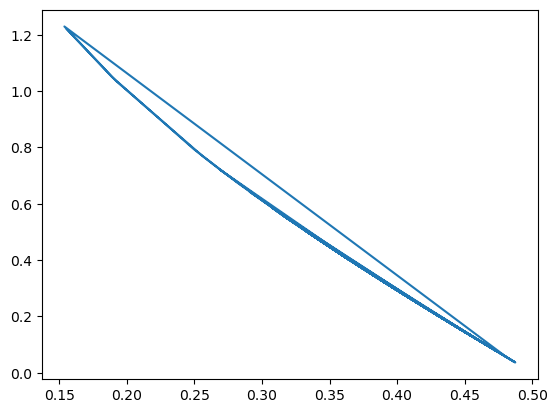

Iterations:  170 ,   Accuracy: 1.0


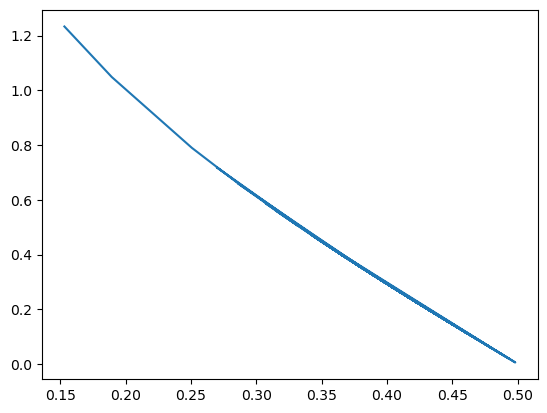

Iterations:  180 ,   Accuracy: 1.0


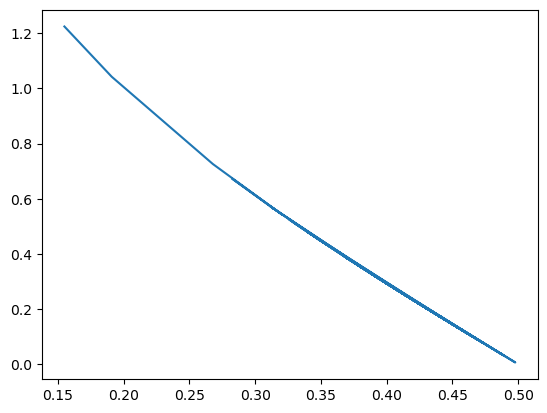

Error rate (0.501850872661736) is greater than 0.5. Repeating loop...
Iterations:  190 ,   Accuracy: 0.9917627677100495


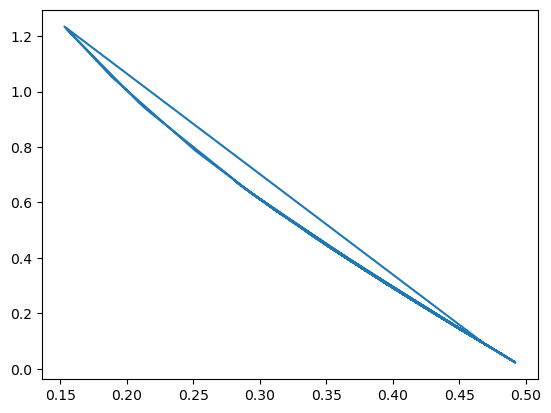

Iterations:  200 ,   Accuracy: 1.0


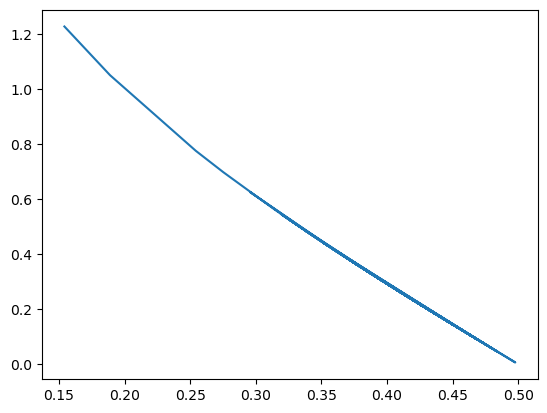

In [411]:
import matplotlib.pyplot as plt

accuracies=[]
adadBoostObjects=[]
for i in range (10,201,10):  
    ab = AdaBoost()
    ab.fit(df, Labels_Train,i) 
    adadBoostObjects.append(ab)
    # Predict on test set
    y_pred = ab.predict(df)
    acc = accuracy(Labels_Train, y_pred)
    print('Iterations: ',i,",   Accuracy:", acc)
    
    df_Test = pd.read_csv('Test.txt',header=None)
    df_Test=df_Test.to_numpy()
    y_Test_pred = ab.predict(df_Test)
   
    y_Test_pred=y_Test_pred.replace(1,3)
    y_Test_pred=y_Test_pred.replace(-1,5)
    
    writeToFile(i,y_Test_pred)
    plt.plot((ab.training_errors),ab.alphas)
    
   
    plt.show()
    accuracies.append(acc)

Iterations:  10 ,   Accuracy: 0.9398682042833608


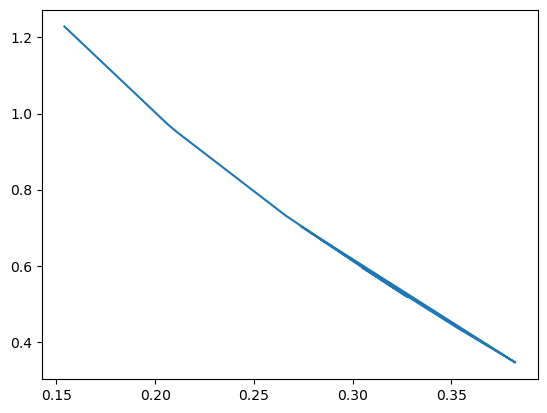

Iterations:  20 ,   Accuracy: 0.9612850082372323


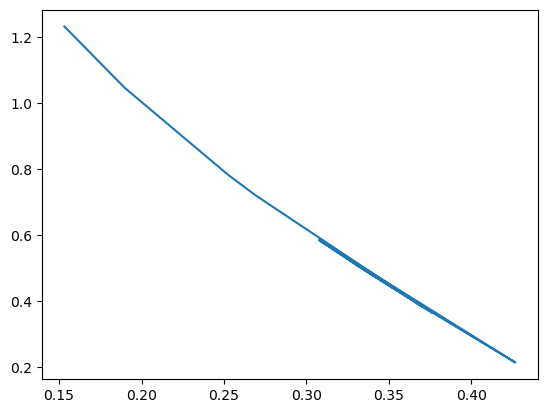

Iterations:  30 ,   Accuracy: 0.9736408566721582


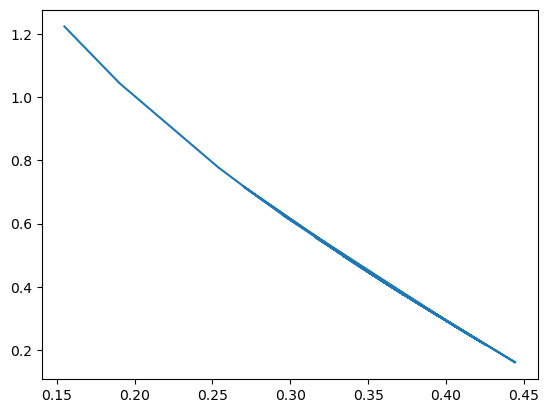

Iterations:  40 ,   Accuracy: 0.9761120263591433


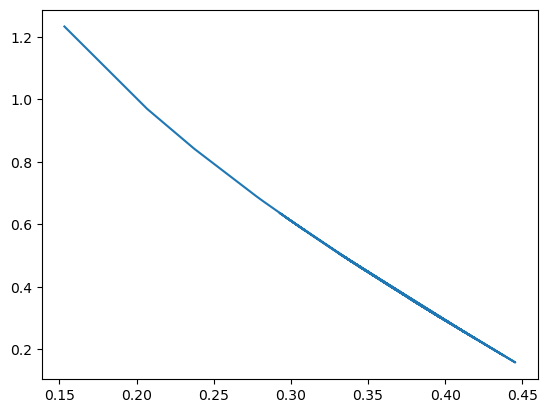

Iterations:  50 ,   Accuracy: 0.9835255354200988


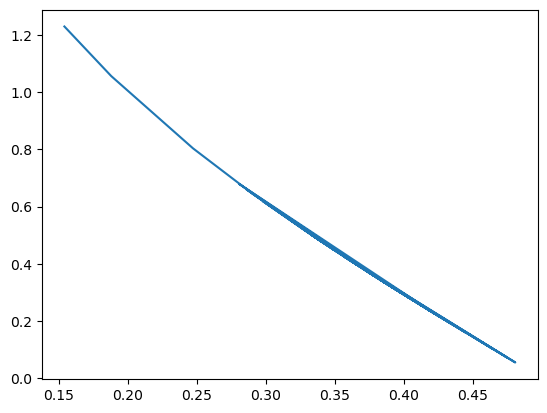

Iterations:  60 ,   Accuracy: 0.9827018121911038


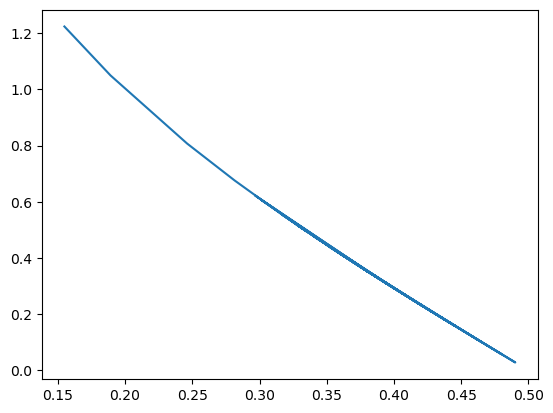

Error rate (0.505890635391849) is greater than 0.5. Repeating loop...
Iterations:  70 ,   Accuracy: 0.9744645799011532


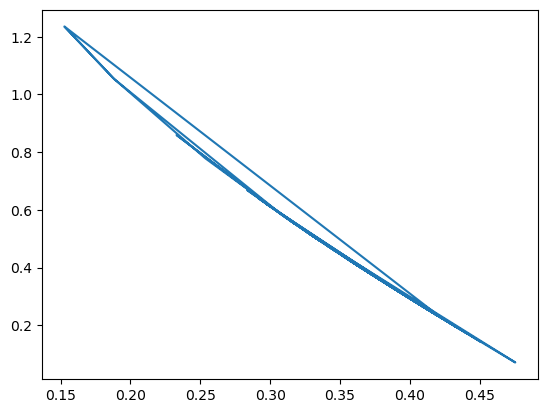

Iterations:  80 ,   Accuracy: 0.9884678747940692


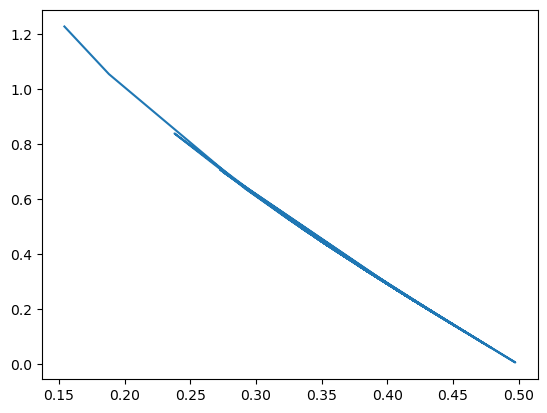

Iterations:  90 ,   Accuracy: 0.9917627677100495


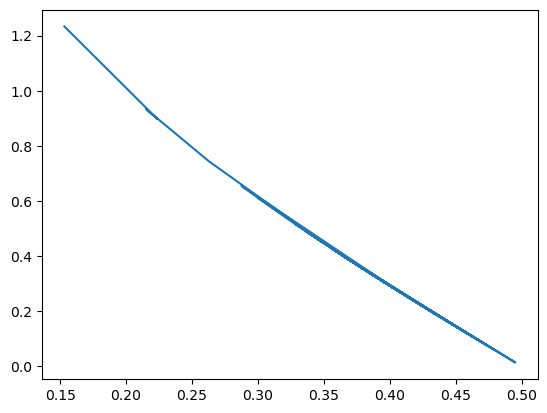

Iterations:  100 ,   Accuracy: 0.9925864909390445


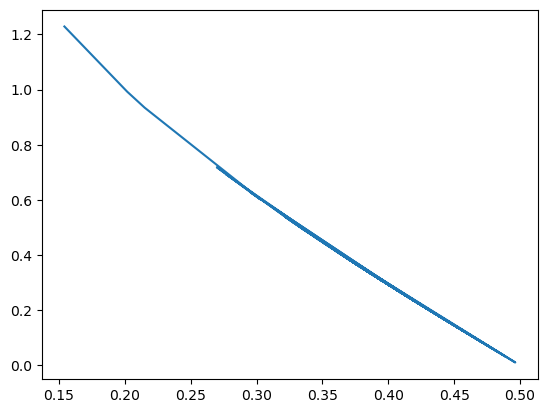

Error rate (0.5062101218235109) is greater than 0.5. Repeating loop...
Iterations:  110 ,   Accuracy: 0.9818780889621087


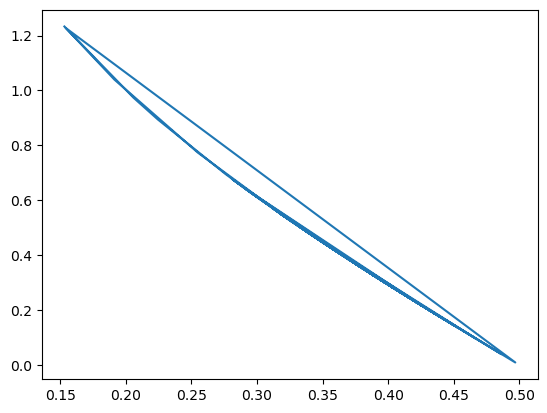

Iterations:  120 ,   Accuracy: 0.9975288303130149


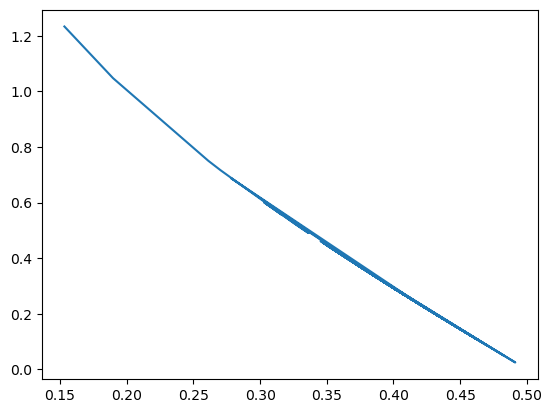

Error rate (0.5090234402031018) is greater than 0.5. Repeating loop...
Iterations:  130 ,   Accuracy: 0.9868204283360791


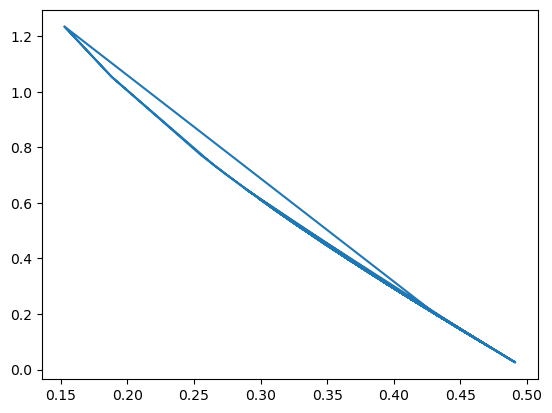

Error rate (0.5064504310361483) is greater than 0.5. Repeating loop...
Iterations:  140 ,   Accuracy: 0.9909390444810544


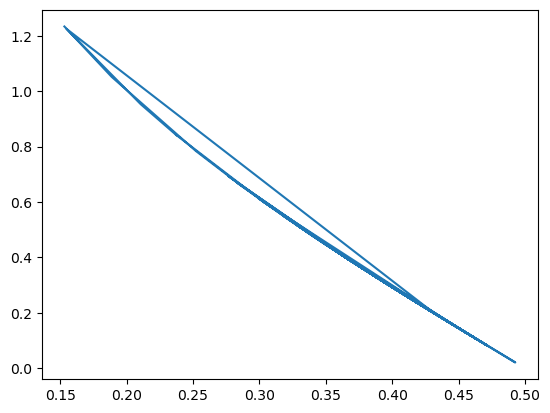

Iterations:  150 ,   Accuracy: 0.999176276771005


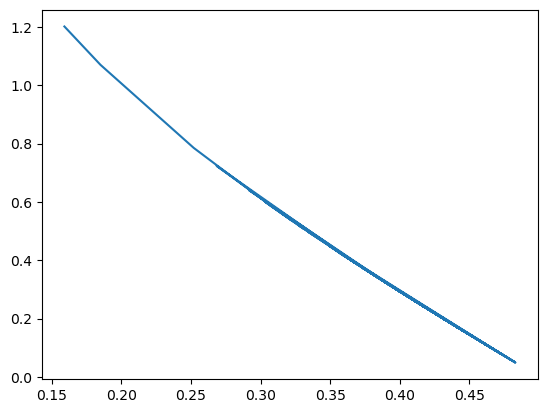

Error rate (0.5085072915043732) is greater than 0.5. Repeating loop...
Iterations:  160 ,   Accuracy: 0.9909390444810544


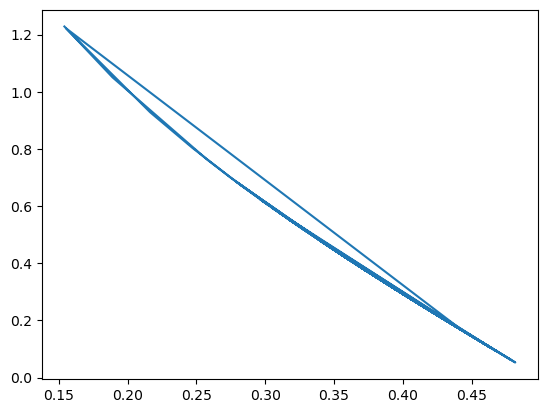

Error rate (0.5026278553082467) is greater than 0.5. Repeating loop...
Iterations:  170 ,   Accuracy: 0.9901153212520593


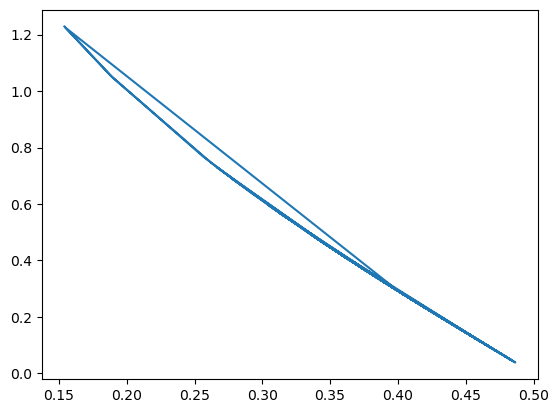

Iterations:  180 ,   Accuracy: 1.0


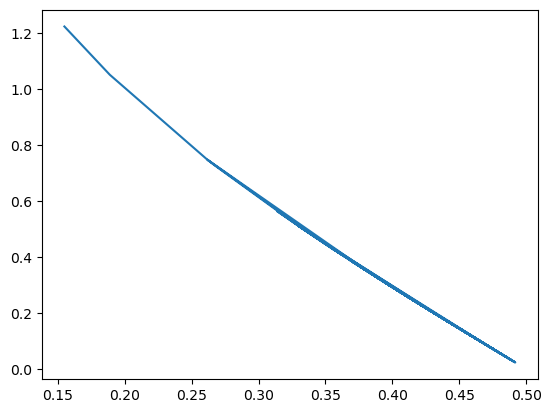

Iterations:  190 ,   Accuracy: 1.0


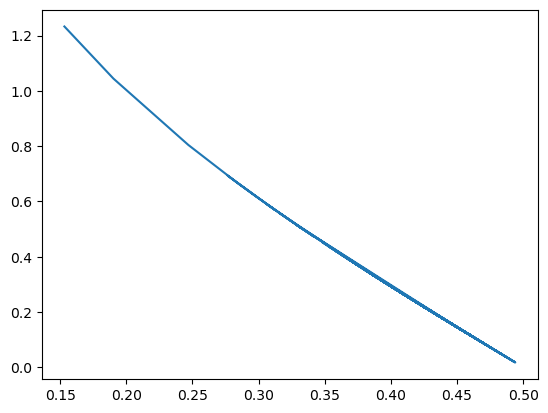

Error rate (0.5035215329835074) is greater than 0.5. Repeating loop...
Error rate (0.5235631415254209) is greater than 0.5. Repeating loop...
Iterations:  200 ,   Accuracy: 0.9909390444810544


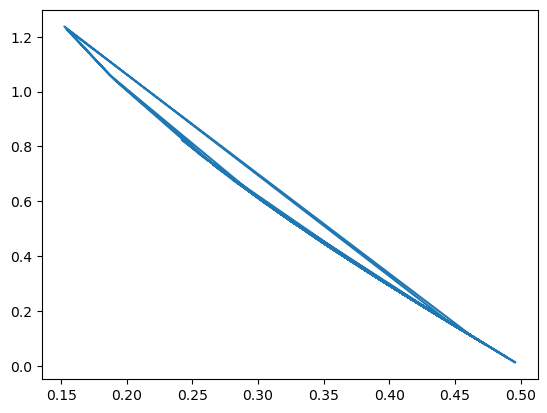

In [490]:
import matplotlib.pyplot as plt

accuracies1=[]
adadBoostObjects=[]
for i in range (10,201,10):  
    ab = AdaBoost()
    ab.fit(df, Labels_Train,i)
    adadBoostObjects.append(ab)
    # Predict on test set
    y_pred = ab.predict(df)
    acc = accuracy(Labels_Train, y_pred)
    print('Iterations: ',i,",   Accuracy:", acc)
    
    df_Test = pd.read_csv('Test.txt',header=None)
    df_Test=df_Test.to_numpy()
    y_Test_pred = ab.predict(df_Test)
   
    y_Test_pred=y_Test_pred.replace(1,3)
    y_Test_pred=y_Test_pred.replace(-1,5)
    
    writeToFile(i,y_Test_pred)
    plt.plot((ab.training_errors),ab.alphas)

    plt.show()
    accuracies1.append(acc)

<b>Graph of Training error rate with Alpha</b>

[0.9266886326194399, 0.9563426688632619, 0.9604612850082372, 0.9719934102141681, 0.9769357495881383, 0.9785831960461285, 0.9777594728171335, 0.9802306425041186, 0.9835255354200988, 0.9884678747940692, 0.9868204283360791, 0.9909390444810544, 0.985996705107084, 0.9744645799011532, 0.9917627677100495, 0.9967051070840197, 0.9925864909390445, 0.985996705107084, 0.9983525535420099, 0.9975288303130149]


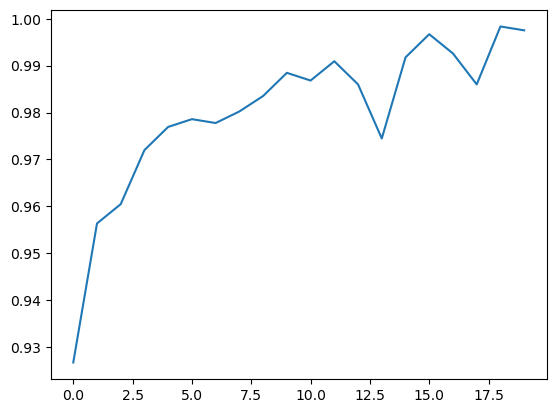

In [368]:
print(accuracies)
plt.plot(range(len(accuracies)), accuracies)
plt.show()

<b>Output When Ensambles are increased from 200 to 300</b>

[0.92833607907743, 0.9489291598023064, 0.9670510708401977, 0.9761120263591433, 0.9752883031301482, 0.9761120263591433, 0.985172981878089, 0.9818780889621087, 0.984349258649094, 0.971169686985173, 0.9884678747940692, 0.9892915980230642, 0.9785831960461285, 0.9892915980230642, 0.9802306425041186, 0.9925864909390445, 0.9950576606260296, 0.9950576606260296, 0.9983525535420099, 0.9876441515650741, 0.999176276771005, 0.9876441515650741, 0.9868204283360791, 0.9901153212520593, 0.9909390444810544, 1.0, 0.984349258649094, 1.0, 0.9942339373970346, 1.0]


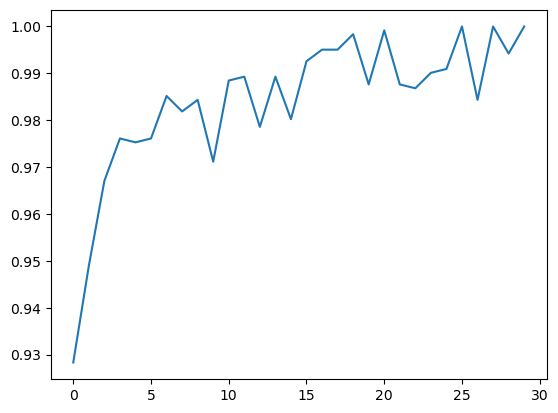

In [348]:
print(accuracies)
plt.plot(range(len(accuracies)), accuracies)
plt.show()

In [308]:
from sklearn.tree import DecisionTreeClassifier

dc =DecisionTreeClassifier(max_depth=1) 
dc.fit(df, Labels_Train)
y_pred_SCIKIT_LEARN = dc.predict(df)
acc = accuracy(Labels_Train, y_pred_SCIKIT_LEARN)

print("Accuracy of library implemented Decision Stump:", acc)

Accuracy of library implemented Decision Stump: 0.8467874794069192


In [449]:
import matplotlib.pyplot as plt
ds =DecisionStump() 
ds.fit(df, Labels_Train)
y_pred = ds.predict(df)
acc = accuracy(Labels_Train, y_pred)

print("Accuracy of SELF implemented Decision Stump:", acc)

Accuracy of SELF implemented Decision Stump: 0.8467874794069192


<b>Single Decision Tree Using Library</b>

In [509]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(df, Labels_Train)
predictions = classifier.predict(df)

acc = accuracy(Labels_Train, predictions)

print("Accuracy:", acc) 

Accuracy: 1.0


<b>Reading Test Data </b>

In [513]:
df_Test = pd.read_csv('Test.txt',header=None)
df_Test

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-1.0,-1.0,-1.000,-0.593,0.700,1.000,1.000,1.000,1.000,0.853,...,1.000,0.717,0.333,0.162,-0.393,-1.000,-1.000,-1.000,-1.000,-1.0
1,-1.0,-1.0,-1.000,0.264,0.532,-0.210,-0.746,-0.779,-1.000,-1.000,...,0.461,0.418,-0.057,-0.829,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0
2,-1.0,-1.0,-0.983,0.662,-0.509,-1.000,-1.000,-1.000,-1.000,-1.000,...,0.774,1.000,0.802,0.513,0.009,-0.603,-1.000,-1.000,-1.000,-1.0
3,-1.0,-1.0,-1.000,-0.941,-0.120,0.858,1.000,1.000,1.000,0.698,...,0.841,1.000,0.823,0.203,-0.478,-1.000,-1.000,-1.000,-1.000,-1.0
4,-1.0,-1.0,-1.000,-1.000,-0.933,0.461,0.779,0.584,0.584,0.584,...,1.000,0.857,0.371,-0.397,-0.949,-1.000,-1.000,-1.000,-1.000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-0.945,...,0.132,0.418,0.633,0.541,0.418,0.259,-0.625,-0.746,-0.883,-1.0
322,-1.0,-1.0,-1.000,-1.000,-1.000,-0.565,0.388,1.000,1.000,1.000,...,-0.634,-0.126,0.383,1.000,1.000,0.970,0.207,0.045,-0.967,-1.0
323,-1.0,-1.0,-1.000,-0.939,0.536,1.000,1.000,1.000,0.871,0.264,...,1.000,1.000,1.000,1.000,1.000,0.748,0.026,-0.827,-1.000,-1.0
324,-1.0,-1.0,-1.000,-0.885,-0.280,-0.411,-0.920,-0.920,-0.920,-0.920,...,0.389,1.000,1.000,1.000,0.868,-0.400,-0.998,-1.000,-1.000,-1.0


In [517]:
df_Test=df_Test.to_numpy()

In [518]:
y_Test_pred = ab.predict(df_Test)
y_Test_pred

0      1
1      1
2     -1
3      1
4      1
      ..
321   -1
322   -1
323    1
324   -1
325   -1
Length: 326, dtype: int32

In [519]:
y_Test_pred=y_Test_pred.replace(1,3)
y_Test_pred=y_Test_pred.replace(-1,5)

In [424]:
def writeToFile(iter,y_Test_pred):
    file = open(f"Deep_Vora__Output_Iteration_{iter}.txt", "w") 

    for i, item in enumerate(y_Test_pred):
        file.write(str(item) + "\n") # Writing data to the output file

    # Close the file to save changes
    file.close()

In [666]:
y_pred_Decision = classifier.predict(df_Test)

print(y_pred_Decision)


[ 1  1  1  1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1  1  1 -1  1
  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1  1 -1 -1  1 -1  1  1  1 -1  1  1
  1  1 -1 -1 -1 -1 -1 -1 -1  1 -1  1  1  1  1  1  1  1 -1  1 -1  1  1  1
  1  1  1  1  1 -1  1 -1  1 -1 -1  1 -1  1  1  1  1  1 -1  1 -1  1  1  1
 -1  1  1  1  1 -1  1  1 -1 -1  1 -1  1  1  1  1  1 -1  1  1 -1  1  1  1
 -1  1 -1  1  1  1  1 -1  1  1 -1  1  1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1
 -1 -1 -1  1 -1  1 -1  1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1  1
  1  1 -1 -1 -1 -1  1 -1  1 -1  1 -1  1  1  1  1  1 -1 -1 -1 -1 -1 -1  1
  1  1 -1  1  1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1  1 -1  1  1  1 -1 -1 -1
  1  1  1  1  1 -1 -1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1 -1  1  1  1
  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1  1  1
  1  1 -1  1 -1 -1  1 -1  1  1  1 -1 -1  1 -1  1  1 -1 -1  1  1 -1 -1  1
  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1
  1 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1 -1  1]


In [670]:

y_pred_Decision[y_pred_Decision == 1] = 3
y_pred_Decision[y_pred_Decision == -1] = 5


array([3, 3, 3, 3, 5, 5, 5, 5, 3, 3, 3, 3, 5, 5, 5, 5, 3, 3, 3, 5, 3, 3,
       5, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 3, 3, 3, 5, 3, 5, 5, 3, 5, 3, 3,
       3, 5, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 3, 5, 3, 3, 3, 3, 3, 3, 3,
       5, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 5, 3, 5, 5, 3, 5, 3, 3, 3,
       3, 3, 5, 3, 5, 3, 3, 3, 5, 3, 3, 3, 3, 5, 3, 3, 5, 5, 3, 5, 3, 3,
       3, 3, 3, 5, 3, 3, 5, 3, 3, 3, 5, 3, 5, 3, 3, 3, 3, 5, 3, 3, 5, 3,
       3, 3, 5, 5, 3, 5, 5, 3, 5, 5, 3, 5, 5, 5, 5, 3, 5, 3, 5, 3, 5, 5,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 3, 3, 3, 5, 5, 5, 5, 3, 5,
       3, 5, 3, 5, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 3, 3, 3, 5, 3, 3, 5,
       5, 5, 5, 5, 3, 5, 3, 5, 5, 3, 3, 5, 3, 3, 3, 5, 5, 5, 3, 3, 3, 3,
       3, 5, 5, 5, 3, 3, 5, 3, 3, 3, 5, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 5,
       5, 5, 5, 5, 5, 3, 3, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 3, 3, 3,
       3, 3, 5, 3, 5, 5, 3, 5, 3, 3, 3, 5, 5, 3, 5, 3, 3, 5, 5, 3, 3, 5,
       5, 3, 3, 5, 5, 5, 3, 5, 5, 5, 5, 5, 3, 3, 5,

In [671]:
file = open("Deep_Vora__OutputDecisionTree.txt", "w") 

for i, item in enumerate(y_pred_Decision):
    file.write(str(item) + "\n")

# Close the file to save changes
file.close()

Iterations:  10 ,   Accuracy: 0.9373970345963756


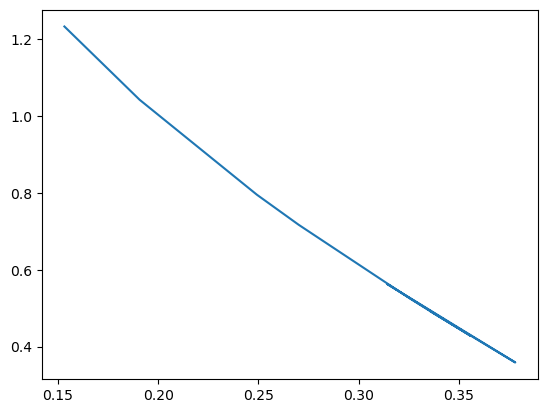

Iterations:  20 ,   Accuracy: 0.9579901153212521


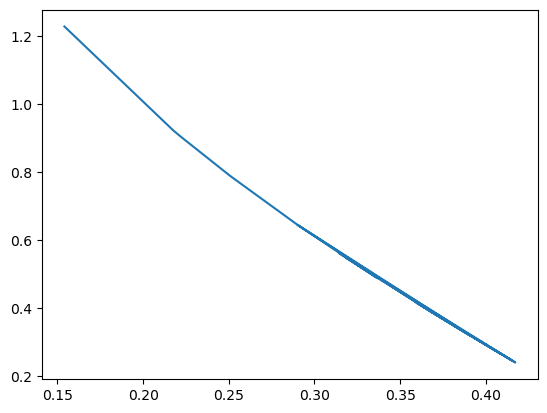

Iterations:  30 ,   Accuracy: 0.9703459637561779


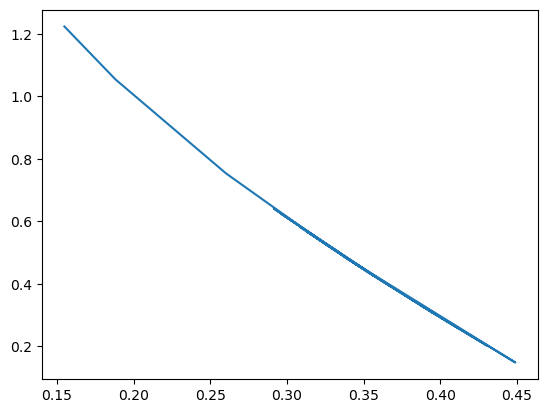

Iterations:  40 ,   Accuracy: 0.9744645799011532


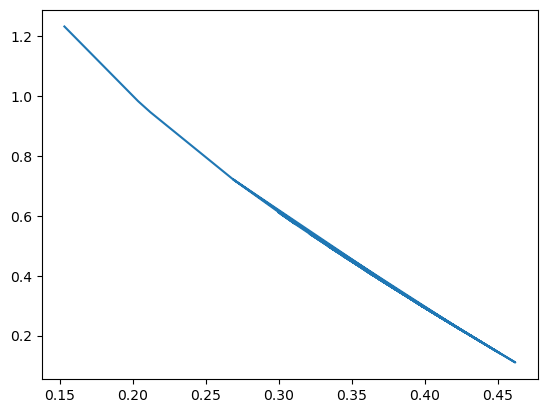

Iterations:  50 ,   Accuracy: 0.9794069192751236


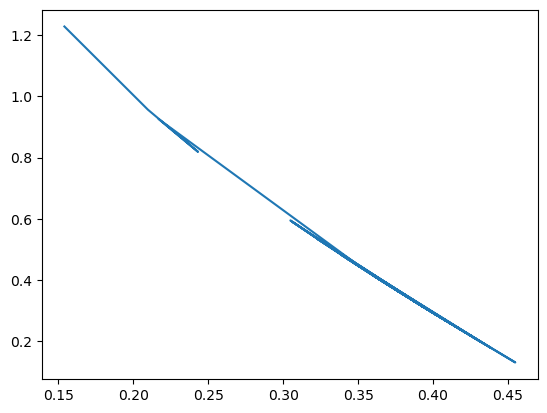

Iterations:  60 ,   Accuracy: 0.9876441515650741


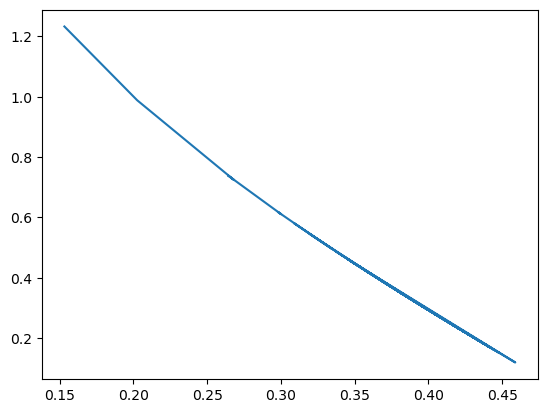

Error rate (0.5123714886752542) is greater than 0.5. Repeating loop...
Iterations:  70 ,   Accuracy: 0.9752883031301482


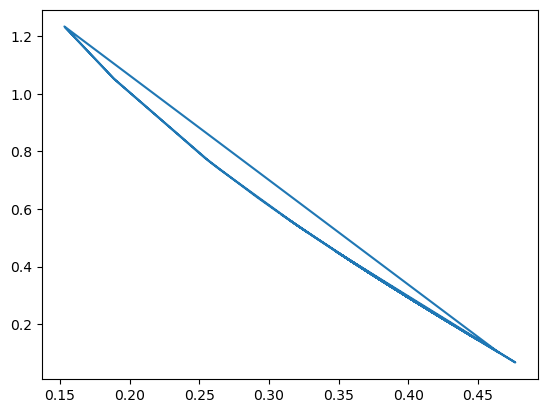

Error rate (0.5005850427313169) is greater than 0.5. Repeating loop...
Iterations:  80 ,   Accuracy: 0.9810543657331137


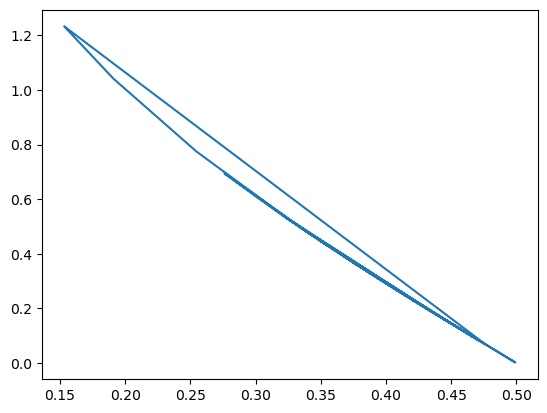

Error rate (0.5009619145101959) is greater than 0.5. Repeating loop...
Iterations:  90 ,   Accuracy: 0.9752883031301482


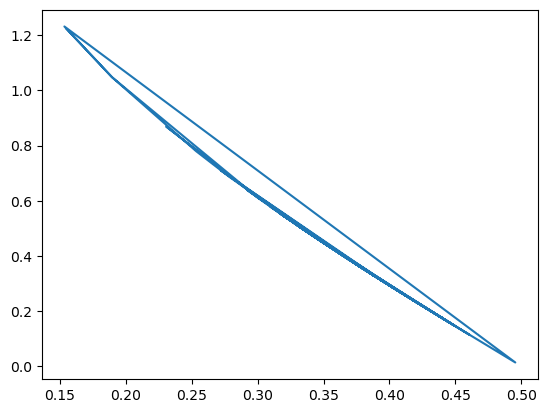

Iterations:  100 ,   Accuracy: 0.9901153212520593


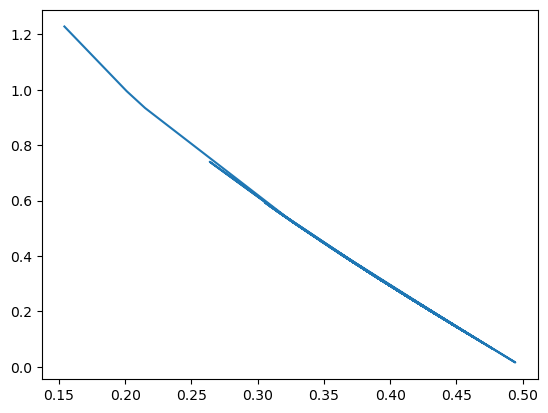

Iterations:  110 ,   Accuracy: 0.9934102141680395


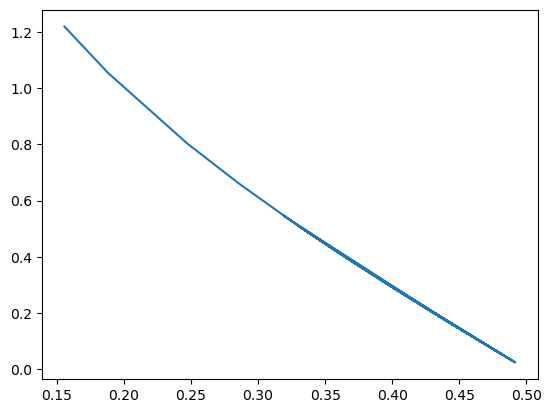

Iterations:  120 ,   Accuracy: 0.9950576606260296


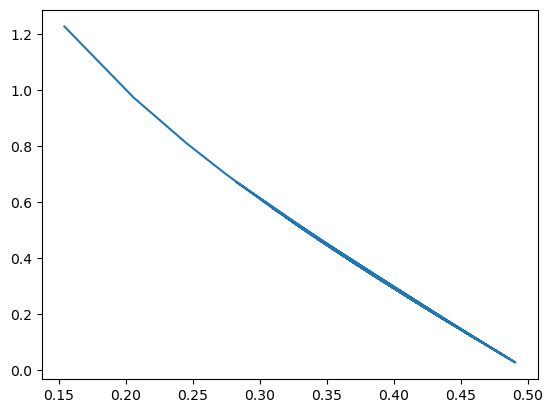

Error rate (0.5051581448665314) is greater than 0.5. Repeating loop...
Iterations:  130 ,   Accuracy: 0.984349258649094


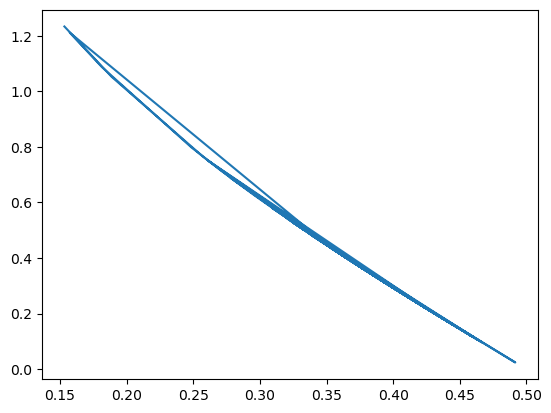

Error rate (0.5216095545937488) is greater than 0.5. Repeating loop...
Error rate (0.5002265618405471) is greater than 0.5. Repeating loop...
Iterations:  140 ,   Accuracy: 0.9802306425041186


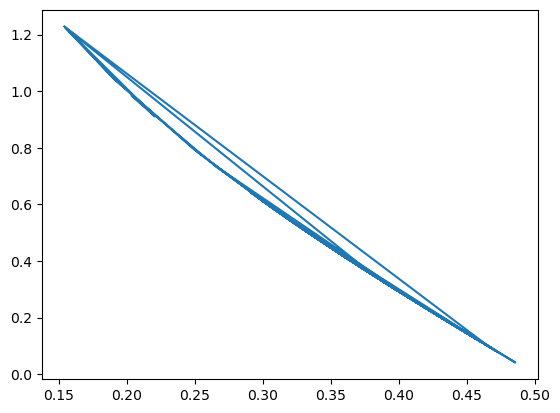

Error rate (0.508517695424053) is greater than 0.5. Repeating loop...
Iterations:  150 ,   Accuracy: 0.9892915980230642


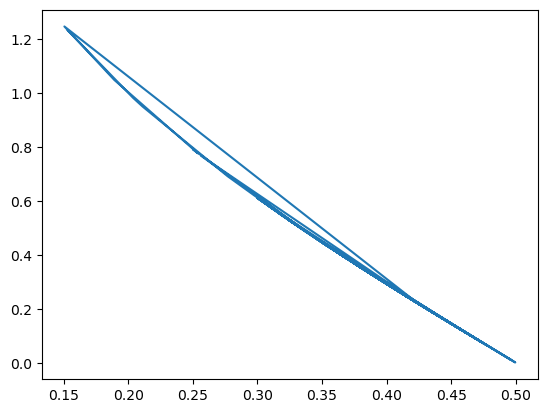

Iterations:  160 ,   Accuracy: 1.0


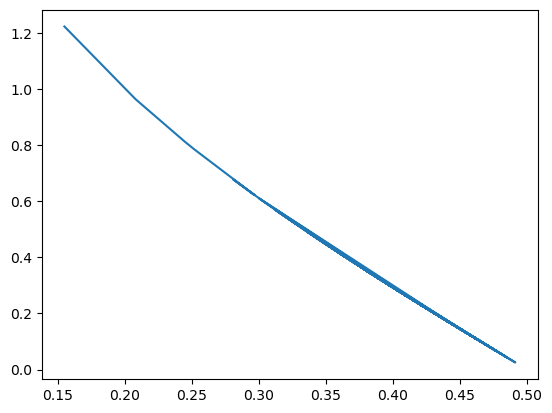

Error rate (0.5150702439530067) is greater than 0.5. Repeating loop...
Iterations:  170 ,   Accuracy: 0.9925864909390445


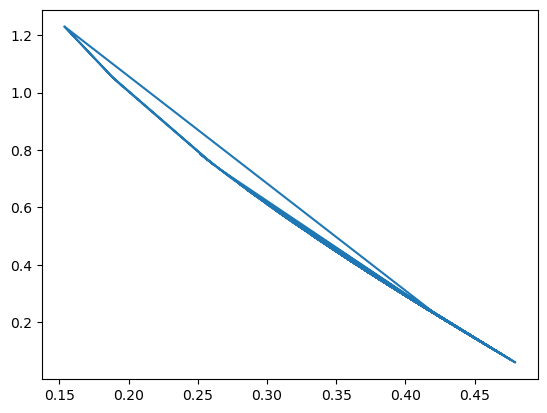

Error rate (0.5081973474371403) is greater than 0.5. Repeating loop...
Iterations:  180 ,   Accuracy: 0.9925864909390445


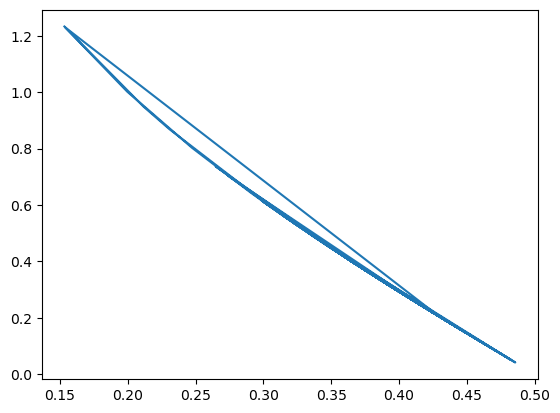

Error rate (0.5035278130319658) is greater than 0.5. Repeating loop...
Error rate (0.5102024524223863) is greater than 0.5. Repeating loop...
Iterations:  190 ,   Accuracy: 0.985996705107084


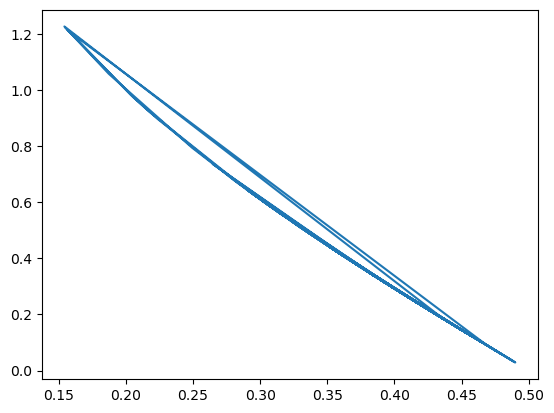

Error rate (0.5157153851399108) is greater than 0.5. Repeating loop...
Error rate (0.5104668374537921) is greater than 0.5. Repeating loop...
Iterations:  200 ,   Accuracy: 0.9876441515650741


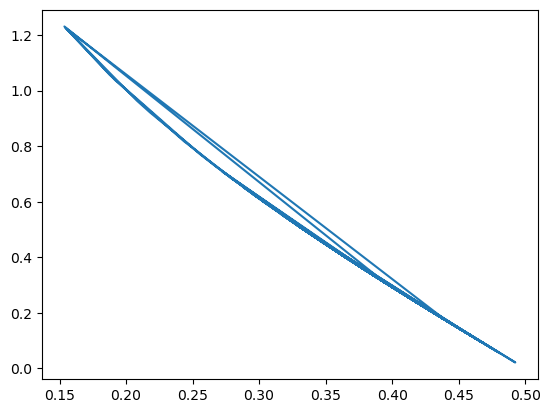

In [423]:
import matplotlib.pyplot as plt
adaboostObjects=[]
accuracies=[]
for i in range (10,201,10):  
    ab = AdaBoost()
    ab.fit(df, Labels_Train,i) 
    
    # Predict on test set
    y_pred = ab.predict(df)
    acc = accuracy(Labels_Train, y_pred)
    print('Iterations: ',i,",   Accuracy:", acc)
    
    df_Test = pd.read_csv('Test.txt',header=None)
    df_Test=df_Test.to_numpy()
    y_Test_pred = ab.predict(df_Test)
   
    y_Test_pred=y_Test_pred.replace(1,3)
    y_Test_pred=y_Test_pred.replace(-1,5)
    
    writeToFile(i,y_Test_pred)
    adaboostObjects.append(ab)
    plt.plot((ab.training_errors),ab.alphas)
    
    plt.show()
    accuracies.append(acc)

In [428]:
count =10
for i in (adaboostObjects): 
    df_Test = pd.read_csv('Test.txt',header=None)
    df_Test=df_Test.to_numpy()
    y_Test_pred = i.predict(df_Test)
   
    y_Test_pred=y_Test_pred.replace(1,3)
    y_Test_pred=y_Test_pred.replace(-1,5)
    
    writeToFile(count,y_Test_pred)
    count+=10

Text(0, 0.5, 'Accuracy')

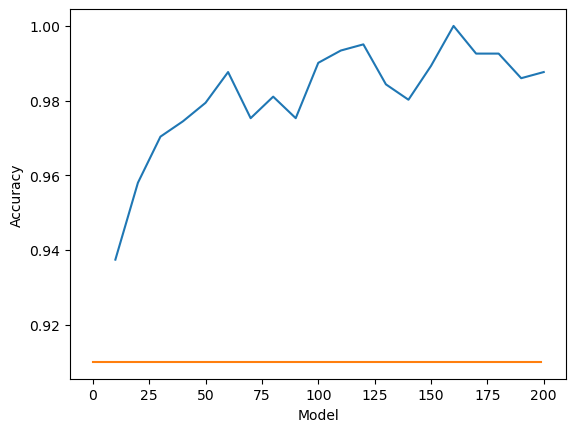

In [438]:
iterations=range(10,201,10)
entries = [0.91 for _ in range(200)]
plt.plot(iterations,accuracies)
plt.plot(entries)
plt.xlabel('Model')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Training Error')

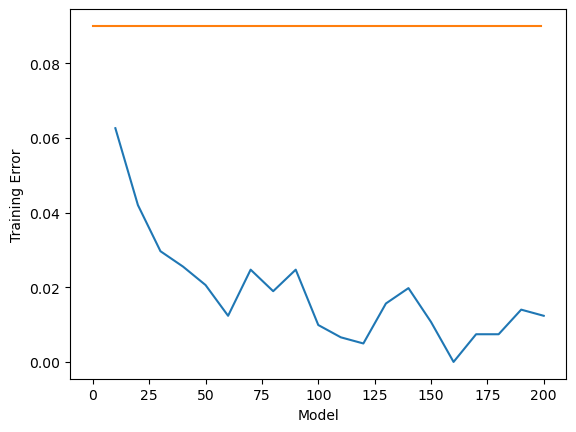

In [440]:
iterations=range(10,201,10)
entries = [(1-0.91) for _ in range(200)]
training_error = [1 - acc for acc in accuracies]
plt.plot(iterations,training_error)
plt.plot(entries)
plt.xlabel('Model')
plt.ylabel('Training Error')
plt.title('AdaBoost Training Error Rate vs Number of Rounds')

In [515]:
# The Test accuracies are taken from Miner
test_accuracies=[0.91,0.90,0.91,0.91,0.93,0.94,0.93,0.93,0.93,0.94,0.93,0.93,0.93,0.94,0.93,0.91,0.94,0.91,0.93,0.95]
#print(accuracies)

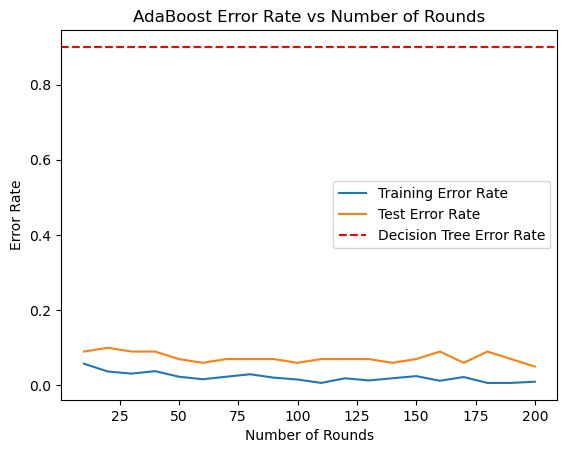

In [516]:
train_error_rates = [1 - a for a in accuracies]
test_error_rate = [1 - acc for acc in test_accuracies]
rounds = list(range(10, 201, 10))

# The error rate for single decision tree
dt_error_rate = 0.9

# Plotting the graph
plt.plot(rounds, train_error_rates, label='Training Error Rate')
plt.plot(rounds, test_error_rate, label='Test Error Rate')
plt.axhline(y=dt_error_rate, color='r', linestyle='--', label='Decision Tree Error Rate')
plt.xlabel('Number of Rounds')
plt.ylabel('Error Rate')
plt.title('AdaBoost Error Rate vs Number of Rounds')
plt.legend()
plt.show()

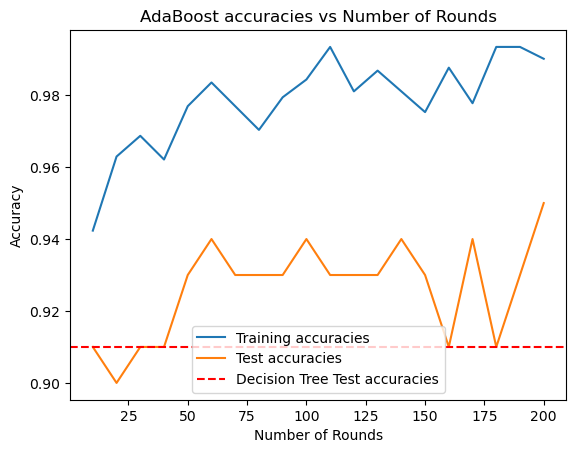

In [510]:
train_error_rates = [1 - acc for acc in accuracies]
test_error_rate = [1 - acc for acc in test_accuracies]
rounds = list(range(10, 201, 10))

# The error rate for single decision tree
dt_error_rate = 0.91

# Plotting the graph
plt.plot(rounds, accuracies, label='Training accuracies')
plt.plot(rounds, test_accuracies, label='Test accuracies')
plt.axhline(y=dt_error_rate, color='r', linestyle='--', label='Decision Tree Test accuracies')
plt.xlabel('Number of Rounds')
plt.ylabel('Accuracy')
plt.title('AdaBoost accuracies vs Number of Rounds')
plt.legend()
plt.show()